In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def load(filepath):
    # Load text file
    with open(filepath, "r") as file:
        text = file.read()
        # print(text)

    # Extract homophily
    homophily_match = re.search(r'Dataset Inter Homophily:([\d.]+)', text)
    homophily = float(homophily_match.group(1)) if homophily_match else None

    # Extract alpha
    alpha_match = re.search(r"'ALPHA':\s*([\d.]+)", text)
    alpha = float(alpha_match.group(1)) if alpha_match else None

    # New model pattern (no train-loss anymore)
    model_pattern = r"""
    (?P<model_name>Temporal\sMultiFix(?:\sDeepwalk)?|MultiLabel\sEvolve\sGCN):\s+
    test-loss:(?P<test_loss_mean>[-+]?\d*\.\d+)\+\-(?P<test_loss_std>[\d.]+)\s+
    test-f1-macro:(?P<f1_macro_mean>[-+]?\d*\.\d+)\+\-(?P<f1_macro_std>[\d.]+)\s+
    test-f1-micro:(?P<f1_micro_mean>[-+]?\d*\.\d+)\+\-(?P<f1_micro_std>[\d.]+)\s+
    test-AP-macro:(?P<ap_macro_mean>[-+]?\d*\.\d+)\+\-(?P<ap_macro_std>[\d.]+)\s+
    test-AUC-ROC:(?P<auc_roc_mean>[-+]?\d*\.\d+)\+\-(?P<auc_roc_std>[\d.]+)
    """

    # Extract matches
    matches = re.finditer(model_pattern, text, re.VERBOSE)
    data = []

    for match in matches:
        entry = match.groupdict()
        entry["homophily"] = homophily
        entry["alpha"] = alpha
        data.append(entry)

    # Create DataFrame
    df = pd.DataFrame(data).replace('MultiFix Evolve GCN', 'MultiLabel Evolve GCN')
    
    # Convert all columns except 'model_name' to float
    for col in df.columns:
        if col != "model_name":
            df[col] = df[col].astype(float)
        
    return df

In [ ]:
# filepaths = ['data\\results_alpha0_2025-06-12_08-13-31.txt',
#              'data\\results_alpha0.5_2025-06-12_17-13-09.txt',
#             'data\\results_alpha1_2025-06-12_06-21-41.txt',
#             'data\\results_alpha1.5_2025-06-12_18-07-06.txt',
#             'data\\results_alpha2_2025-06-12_05-23-19.txt',
#             'data\\results_alpha2.5_2025-06-12_18-50-26.txt',
#             'data\\results_alpha3_2025-06-12_04-40-54.txt',
#             'data\\results_alpha4_2025-06-12_04-02-38.txt',
#             'data\\results_alpha5_2025-06-12_03-25-48.txt',
#             'data\\results_alpha6_2025-06-12_11-53-43.txt',
#             'data\\results_alpha7_2025-06-12_12-29-45.txt',
#             'data\\results_alpha8_2025-06-12_13-06-04.txt',
#             'data\\results_alpha9_2025-06-12_13-42-07.txt',
#             'data\\results_alpha10_2025-06-12_14-21-58.txt'
#             ]

# filepaths = ['data\\2025-06-15_17-53-03\\results_alpha0.txt',
#              'data\\2025-06-15_17-53-03\\results_alpha0.5.txt',
#              'data\\2025-06-15_17-53-03\\results_alpha1.txt',
#              'data\\2025-06-15_17-53-03\\results_alpha1.5.txt',
#              'data\\2025-06-15_17-53-03\\results_alpha2.txt',
#              'data\\2025-06-15_17-53-03\\results_alpha2.5.txt',
#              'data\\2025-06-15_17-53-03\\results_alpha3.txt',
#             ]

filepaths = ['data\\experiment1\\results_alpha0.txt',
             'data\\experiment1\\results_alpha0.5.txt',
             'data\\experiment1\\results_alpha1.txt',
             'data\\experiment1\\results_alpha1.5.txt',
             'data\\experiment1\\results_alpha2.txt',
             'data\\experiment1\\results_alpha2.5.txt',
             'data\\experiment1\\results_alpha3.txt',
            ]

df = pd.concat([load(filepath) for filepath in filepaths], axis=0)
df


In [ ]:
metrics = [
    ("test_loss_mean", "test_loss_std", "Test BCE Loss"),
    ("f1_macro_mean", "f1_macro_std", "Test Macro F1 Score"),
    ("f1_micro_mean", "f1_micro_std", 'Test Micro F1 Score'),
    ("ap_macro_mean", "ap_macro_std", "Test Macro Avg. Precision Score"),
    ("auc_roc_mean", "auc_roc_std", "Test AUC-ROC Score"),
]

# Set style
sns.set(style="whitegrid")
colors = [("tab:red","tab:pink"), ("tab:blue", "tab:cyan"), ("tab:green", "tab:olive")]

# Create a plot for each metric
for mean_col, std_col, metric in metrics:
    plt.figure(figsize=(8, 5), dpi=600)
    
    for i, model in enumerate(['Temporal MultiFix', 'Temporal MultiFix Deepwalk', 'MultiLabel Evolve GCN']):
        subset = df[(df['model_name'] == model) & (df['alpha'] <= 3)]
        # plt.errorbar(
        #     # subset["homophily"],
        #     subset["alpha"],
        #     subset[mean_col],
        #     yerr=subset[std_col],
        #     label=model,
        #     marker='o',
        #     capsize=4
        # )

        plt.plot(subset["alpha"], subset[mean_col], label=model, color=colors[i][0])
        plt.fill_between(subset["alpha"], subset[mean_col] - subset[std_col], subset[mean_col] + subset[std_col],
                         color=colors[i][1], alpha=0.3, label='_nolegend_')

    # Build custom tick labels
    unique_alphas = sorted(subset["alpha"].unique())
    ticks = unique_alphas
    tick_labels = [
        f"{alpha:.1f}\n({subset[subset['alpha'] == alpha]['homophily'].iloc[0]:.4f})"
        for alpha in ticks
    ]
    plt.xticks(ticks, tick_labels)

    # plt.title(f"{mean_col.replace('_mean', '').replace('_', ' ').title()} vs. Homophily")
    plt.title(f"{metric} vs. Alpha")
    # plt.xlabel("Homophily")
    plt.xlabel("Alpha\n(Inter Homophily)")
    plt.ylabel(metric)
    plt.legend(title="Model")
    # plt.xscale("log")
    # plt.ylim(0,1.5)
    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(dpi=600)
plt.plot(df[df['model_name'] == 'Temporal MultiFix']['alpha'], df[df['model_name'] == 'Temporal MultiFix']['homophily'])
plt.ylabel('Inter Homophily')
plt.xlabel('Alpha')
# plt.title()
plt.show()

In [ ]:
def load2(filepath):
    # Load text file
    with open(filepath, "r") as file:
        text = file.read()
        # print(text)

    # Extract homophily
    homophily_match = re.search(r'Dataset Inter Homophily:([\d.]+)', text)
    homophily = float(homophily_match.group(1)) if homophily_match else None

    # Extract alpha
    alpha_match = re.search(r"'ALPHA':\s*([\d.]+)", text)
    alpha = float(alpha_match.group(1)) if alpha_match else None

    # New model pattern with optional (EmbDim=XX)
    model_pattern = r"""
    (?P<model_name>Temporal\sMultiFix(?:\sDeepwalk)?|MultiFix\sEvolve\sGCN)    # model name
    (?:\s*\(EmbDim=(?P<embedding_dim>\d+)\))?                                   # optional EmbDim
    :\s+
    test-loss:(?P<test_loss_mean>[-+]?\d*\.\d+)\+\-(?P<test_loss_std>[\d.]+)\s+
    test-f1-macro:(?P<f1_macro_mean>[-+]?\d*\.\d+)\+\-(?P<f1_macro_std>[\d.]+)\s+
    test-f1-micro:(?P<f1_micro_mean>[-+]?\d*\.\d+)\+\-(?P<f1_micro_std>[\d.]+)\s+
    test-AP-macro:(?P<ap_macro_mean>[-+]?\d*\.\d+)\+\-(?P<ap_macro_std>[\d.]+)\s+
    test-AUC-ROC:(?P<auc_roc_mean>[-+]?\d*\.\d+)\+\-(?P<auc_roc_std>[\d.]+)
    """

    # Extract matches
    matches = re.finditer(model_pattern, text, re.VERBOSE)
    data = []

    for match in matches:
        entry = match.groupdict()
        entry["homophily"] = homophily
        entry["alpha"] = alpha
        
        # If embedding_dim is None, set to NaN
        entry["embedding_dim"] = float(entry["embedding_dim"]) if entry["embedding_dim"] else float('nan')
        
        data.append(entry)

    # Create DataFrame
    df = pd.DataFrame(data)

    # Convert all columns except 'model_name' to float
    for col in df.columns:
        if col != "model_name":
            df[col] = df[col].astype(float)
        
    return df

In [ ]:
filepaths = ['data\\2025-06-20_01-53-14\\results_alpha0.txt',
             'data\\2025-06-19_16-35-31\\results_alpha1.txt',
             'data\\2025-06-19_16-35-31\\results_alpha2.txt',
            ]

df = pd.concat([load2(filepath) for filepath in filepaths], axis=0)
df

In [ ]:
metrics = [
    ("test_loss_mean", "test_loss_std", "Test BCE Loss"),
    ("f1_macro_mean", "f1_macro_std", "Test Macro F1 Score"),
    ("f1_micro_mean", "f1_micro_std", 'Test Micro F1 Score'),
    ("ap_macro_mean", "ap_macro_std", "Test Macro Avg. Precision Score"),
    ("auc_roc_mean", "auc_roc_std", "Test AUC-ROC Score"),
]

# Set style
sns.set(style="whitegrid")
colors = [("tab:blue", "tab:cyan"), ("tab:red","tab:pink"), ("tab:green", "tab:olive")]

# Create a plot for each metric
for mean_col, std_col, metric in metrics:
    plt.figure(figsize=(8, 5), dpi=600)
    
    for i, model in enumerate(df['embedding_dim'].unique()):
        subset = df[(df['embedding_dim'] == model) & (df['alpha'] <= 3)]
        # plt.errorbar(
        #     # subset["homophily"],
        #     subset["alpha"],
        #     subset[mean_col],
        #     yerr=subset[std_col],
        #     label=model,
        #     marker='o',
        #     capsize=4
        # )

        plt.plot(subset["alpha"], subset[mean_col], label=f'Embedding Size = {model}', color=colors[i][0])
        plt.fill_between(subset["alpha"], subset[mean_col] - subset[std_col], subset[mean_col] + subset[std_col],
                         color=colors[i][1], alpha=0.3, label='_nolegend_')

    # Build custom tick labels
    unique_alphas = sorted(subset["alpha"].unique())
    ticks = unique_alphas
    tick_labels = [
        f"{alpha:.1f}\n({subset[subset['alpha'] == alpha]['homophily'].iloc[0]:.4f})"
        for alpha in ticks
    ]
    plt.xticks(ticks, tick_labels)

    # plt.title(f"{mean_col.replace('_mean', '').replace('_', ' ').title()} vs. Homophily")
    plt.title(f"{metric} vs. Alpha")
    # plt.xlabel("Homophily")
    plt.xlabel("Alpha\n(Inter Homophily)")
    plt.ylabel(metric)
    plt.legend(title="Model")
    # plt.xscale("log")
    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(dpi=600)
plt.plot(df[df['embedding_dim'] == 16]['alpha'], df[df['embedding_dim'] == 16]['homophily'])
plt.ylabel('Inter Homophily')
plt.xlabel('Alpha')
# plt.title()
plt.show()

In [4]:
import pickle
import matplotlib.ticker as ticker

In [ ]:
with open('count_list', 'rb') as f:
    count_ls = pickle.load(f)

with open('ratio_list', 'rb') as f:
    ratio_ls = pickle.load(f)

In [ ]:
plt.figure(dpi=600)
for i, alpha in enumerate([0, 0.5, 1, 1.5, 2, 2.5, 3]):
    plt.plot(range(31), count_ls[i], label=f'{alpha}')

plt.xlabel('time step')
plt.ylabel('num. edges')
plt.legend(title='alpha')
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
plt.show(block=False)

In [ ]:
import numpy as np
np.unique(ratio_ls)

In [ ]:
plt.figure(dpi=600)
for i, alpha in enumerate([0, 0.5, 1, 1.5, 2, 2.5, 3]):
    plt.plot(range(31), ratio_ls[i], label=f'{alpha}')

plt.xlabel('time step')
plt.ylabel('num. edges')
plt.legend(title='alpha')
plt.ylim(-0.0015, 0.0015)
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
plt.show(block=False)

In [10]:
def load3(filepath):
    # Load text file
    with open(filepath, "r") as file:
        text = file.read()
        # print(text)

    # Extract homophily
    homophily_match = re.search(r'Dataset Inter Homophily:\s*([\d.]+)', text)
    homophily = float(homophily_match.group(1)) if homophily_match else None

    # Extract alpha
    alpha_match = re.search(r"'ALPHA':\s*([\d.]+)", text)
    alpha = float(alpha_match.group(1)) if alpha_match else None

    # Prepare list to hold parsed entries
    data = []

    # Split into blocks per model
    blocks = text.split("\n\n")
    for block in blocks:
        lines = block.strip().splitlines()
        if len(lines) == 0:
            continue
        
        # First line is "num. label layers = X:"
        header_match = re.match(r'num\. label layers\s*=\s*(\d+):', lines[0])
        if not header_match:
            continue  # skip blocks that are not a model
        
        num_label_layers = int(header_match.group(1))
        
        # Dict to hold this model entry
        entry = {
            "num_label_layers": num_label_layers,
            "homophily": homophily,
            "alpha": alpha
        }
        
        # Now parse each metric line
        for line in lines[1:]:
            metric_match = re.match(r'(\w[\w\- ]+):\s*([\d.]+)\+\-([\d.]+)', line)
            if metric_match:
                metric_name = metric_match.group(1).strip().lower().replace("-", "_").replace(" ", "_")
                mean_val = float(metric_match.group(2))
                std_val = float(metric_match.group(3))
                entry[f"{metric_name}_mean"] = mean_val
                entry[f"{metric_name}_std"] = std_val
        
        data.append(entry)

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Convert all numeric columns to float (just in case)
    for col in df.columns:
        if col != "num_label_layers":
            df[col] = pd.to_numeric(df[col], errors='ignore')
        
    return df

In [11]:
filepaths = ['data\\2025-06-22_22-01-58\\results_alpha0.txt',
             'data\\2025-06-22_22-01-58\\results_alpha1.txt',
             'data\\2025-06-22_22-01-58\\results_alpha2.txt',
            ]

df = pd.concat([load3(filepath) for filepath in filepaths], axis=0)
df

C:\Users\formo\AppData\Local\Temp\ipykernel_21676\3941013240.py:57: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


num_label_layers  homophily  alpha  test_loss_mean  test_loss_std  \
0                10     0.3702    0.0          0.1103         0.0249   
1                 2     0.3702    0.0          0.0241         0.0121   
0                10     0.6141    1.0          0.1711         0.0315   
1                 2     0.6141    1.0          0.0255         0.0125   
0                10     0.7601    2.0          0.1209         0.0241   
1                 2     0.7601    2.0          0.0196         0.0096   

   test_f1_macro_mean  test_f1_macro_std  test_f1_micro_mean  \
0              0.7606             0.0054              0.9608   
1              0.9820             0.0150              0.9970   
0              0.6758             0.0395              0.9378   
1              0.9630             0.0316              0.9968   
0              0.7593             0.0093              0.9591   
1              0.9953             0.0033              0.9989   

   test_f1_micro_std  test_ap_macro_mean  test_ap_macro_std  \
0             0.0061              0.7383             0.0068   
1             0.0020              0.9690             0.0252   
0             0.0134              0.6662             0.0319   
1             0.0020              0.9439             0.0461   
0             0.0085              0.7401             0.0128   
1             0.0007              0.9911             0.0062   

   test_auc_roc_mean  test_auc_roc_std  
0             0.8614            0.0088  
1             0.9880            0.0101  
0             0.8131            0.0202  
1             0.9777            0.0192  
0             0.8611            0.0067  
1             0.9970            0.0018

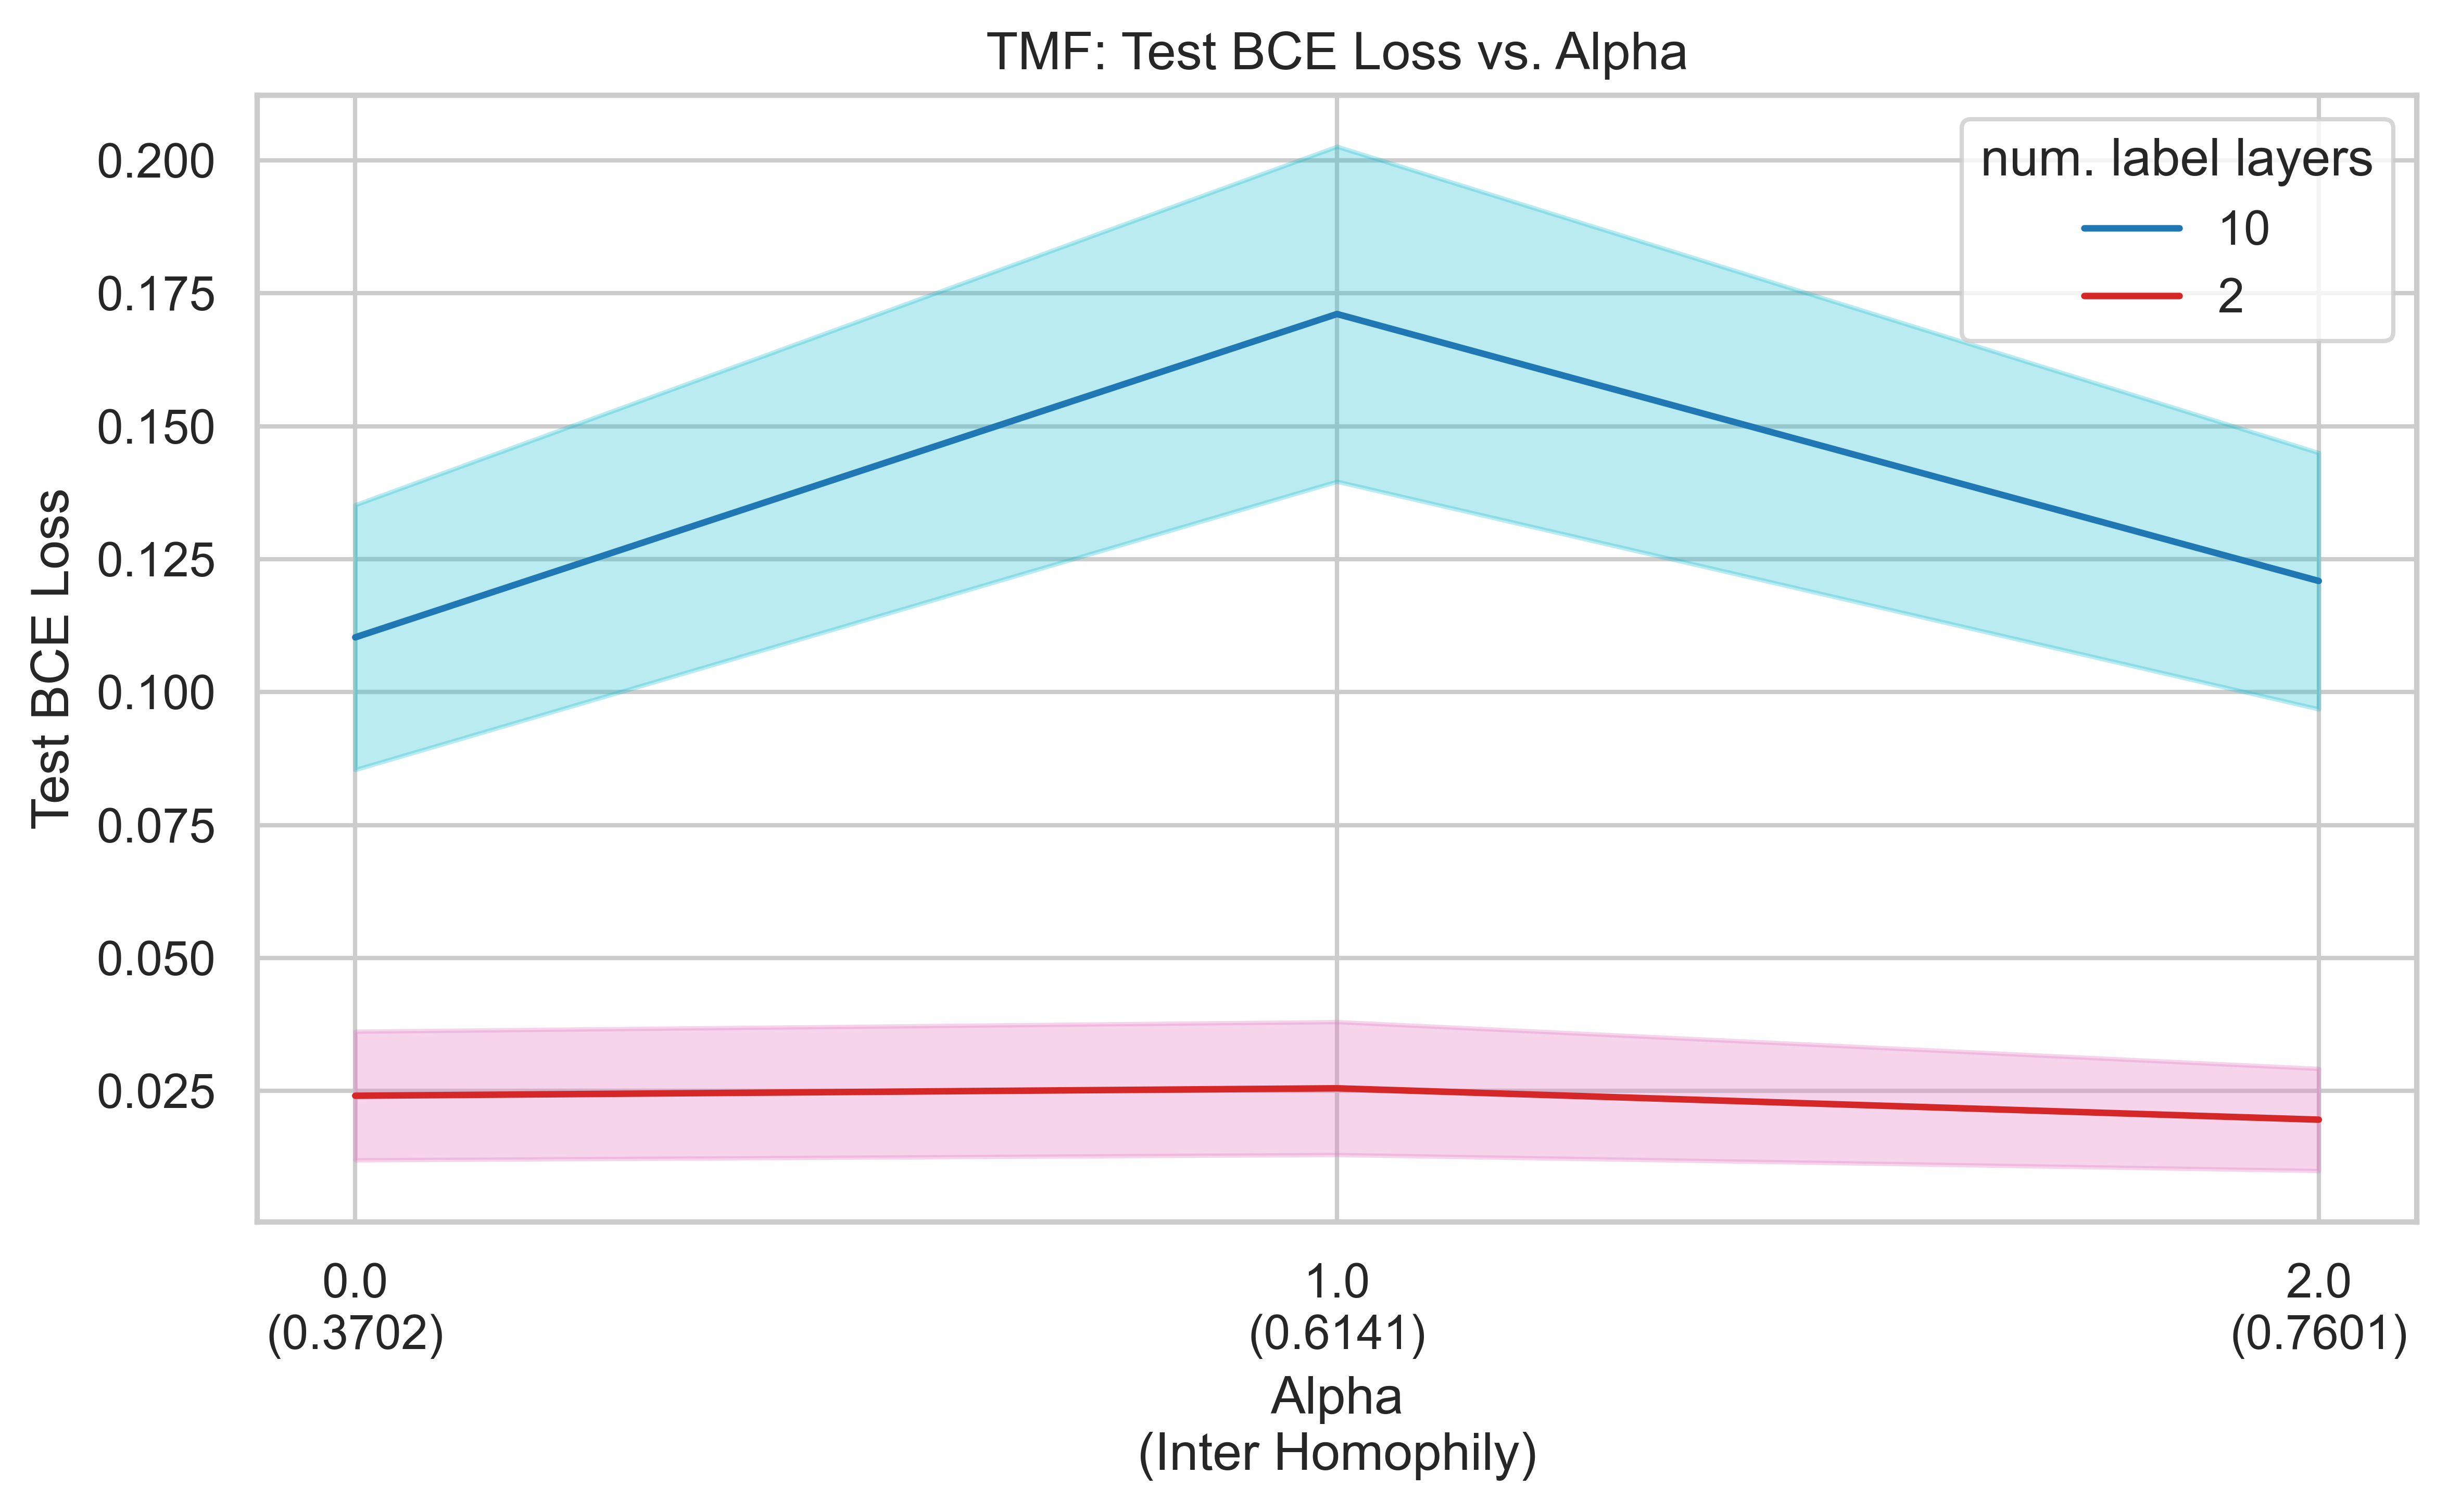

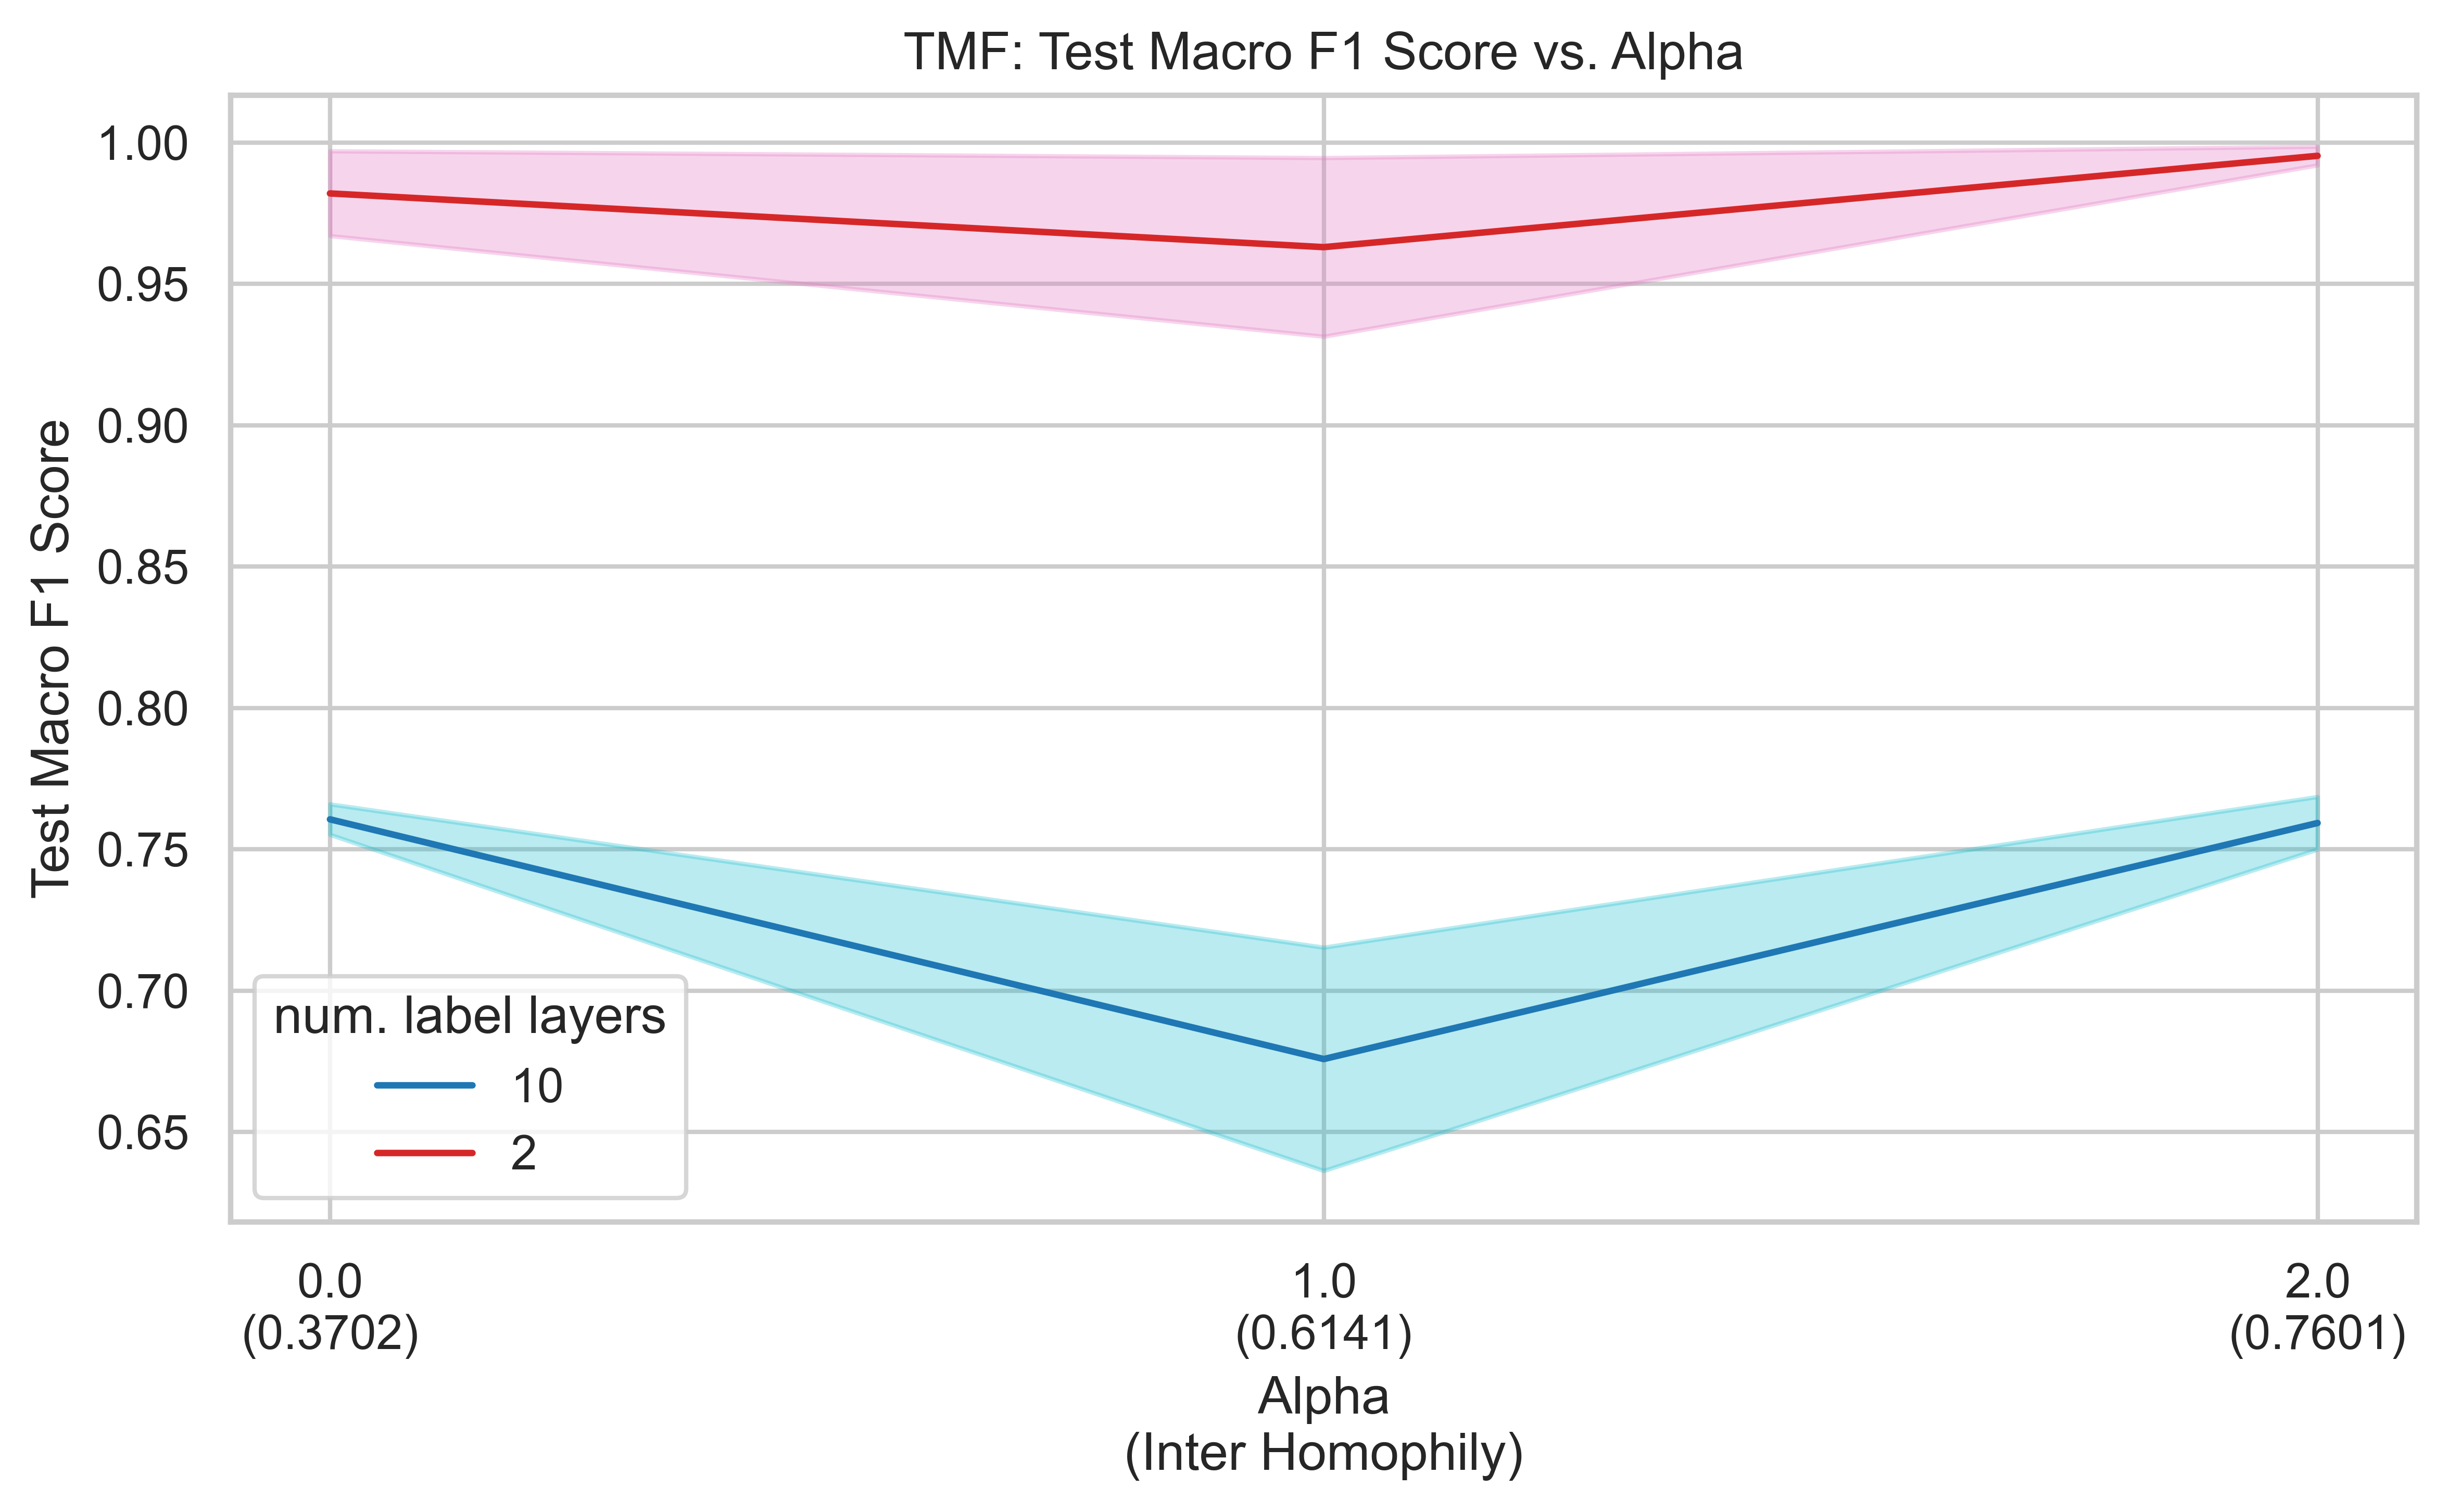

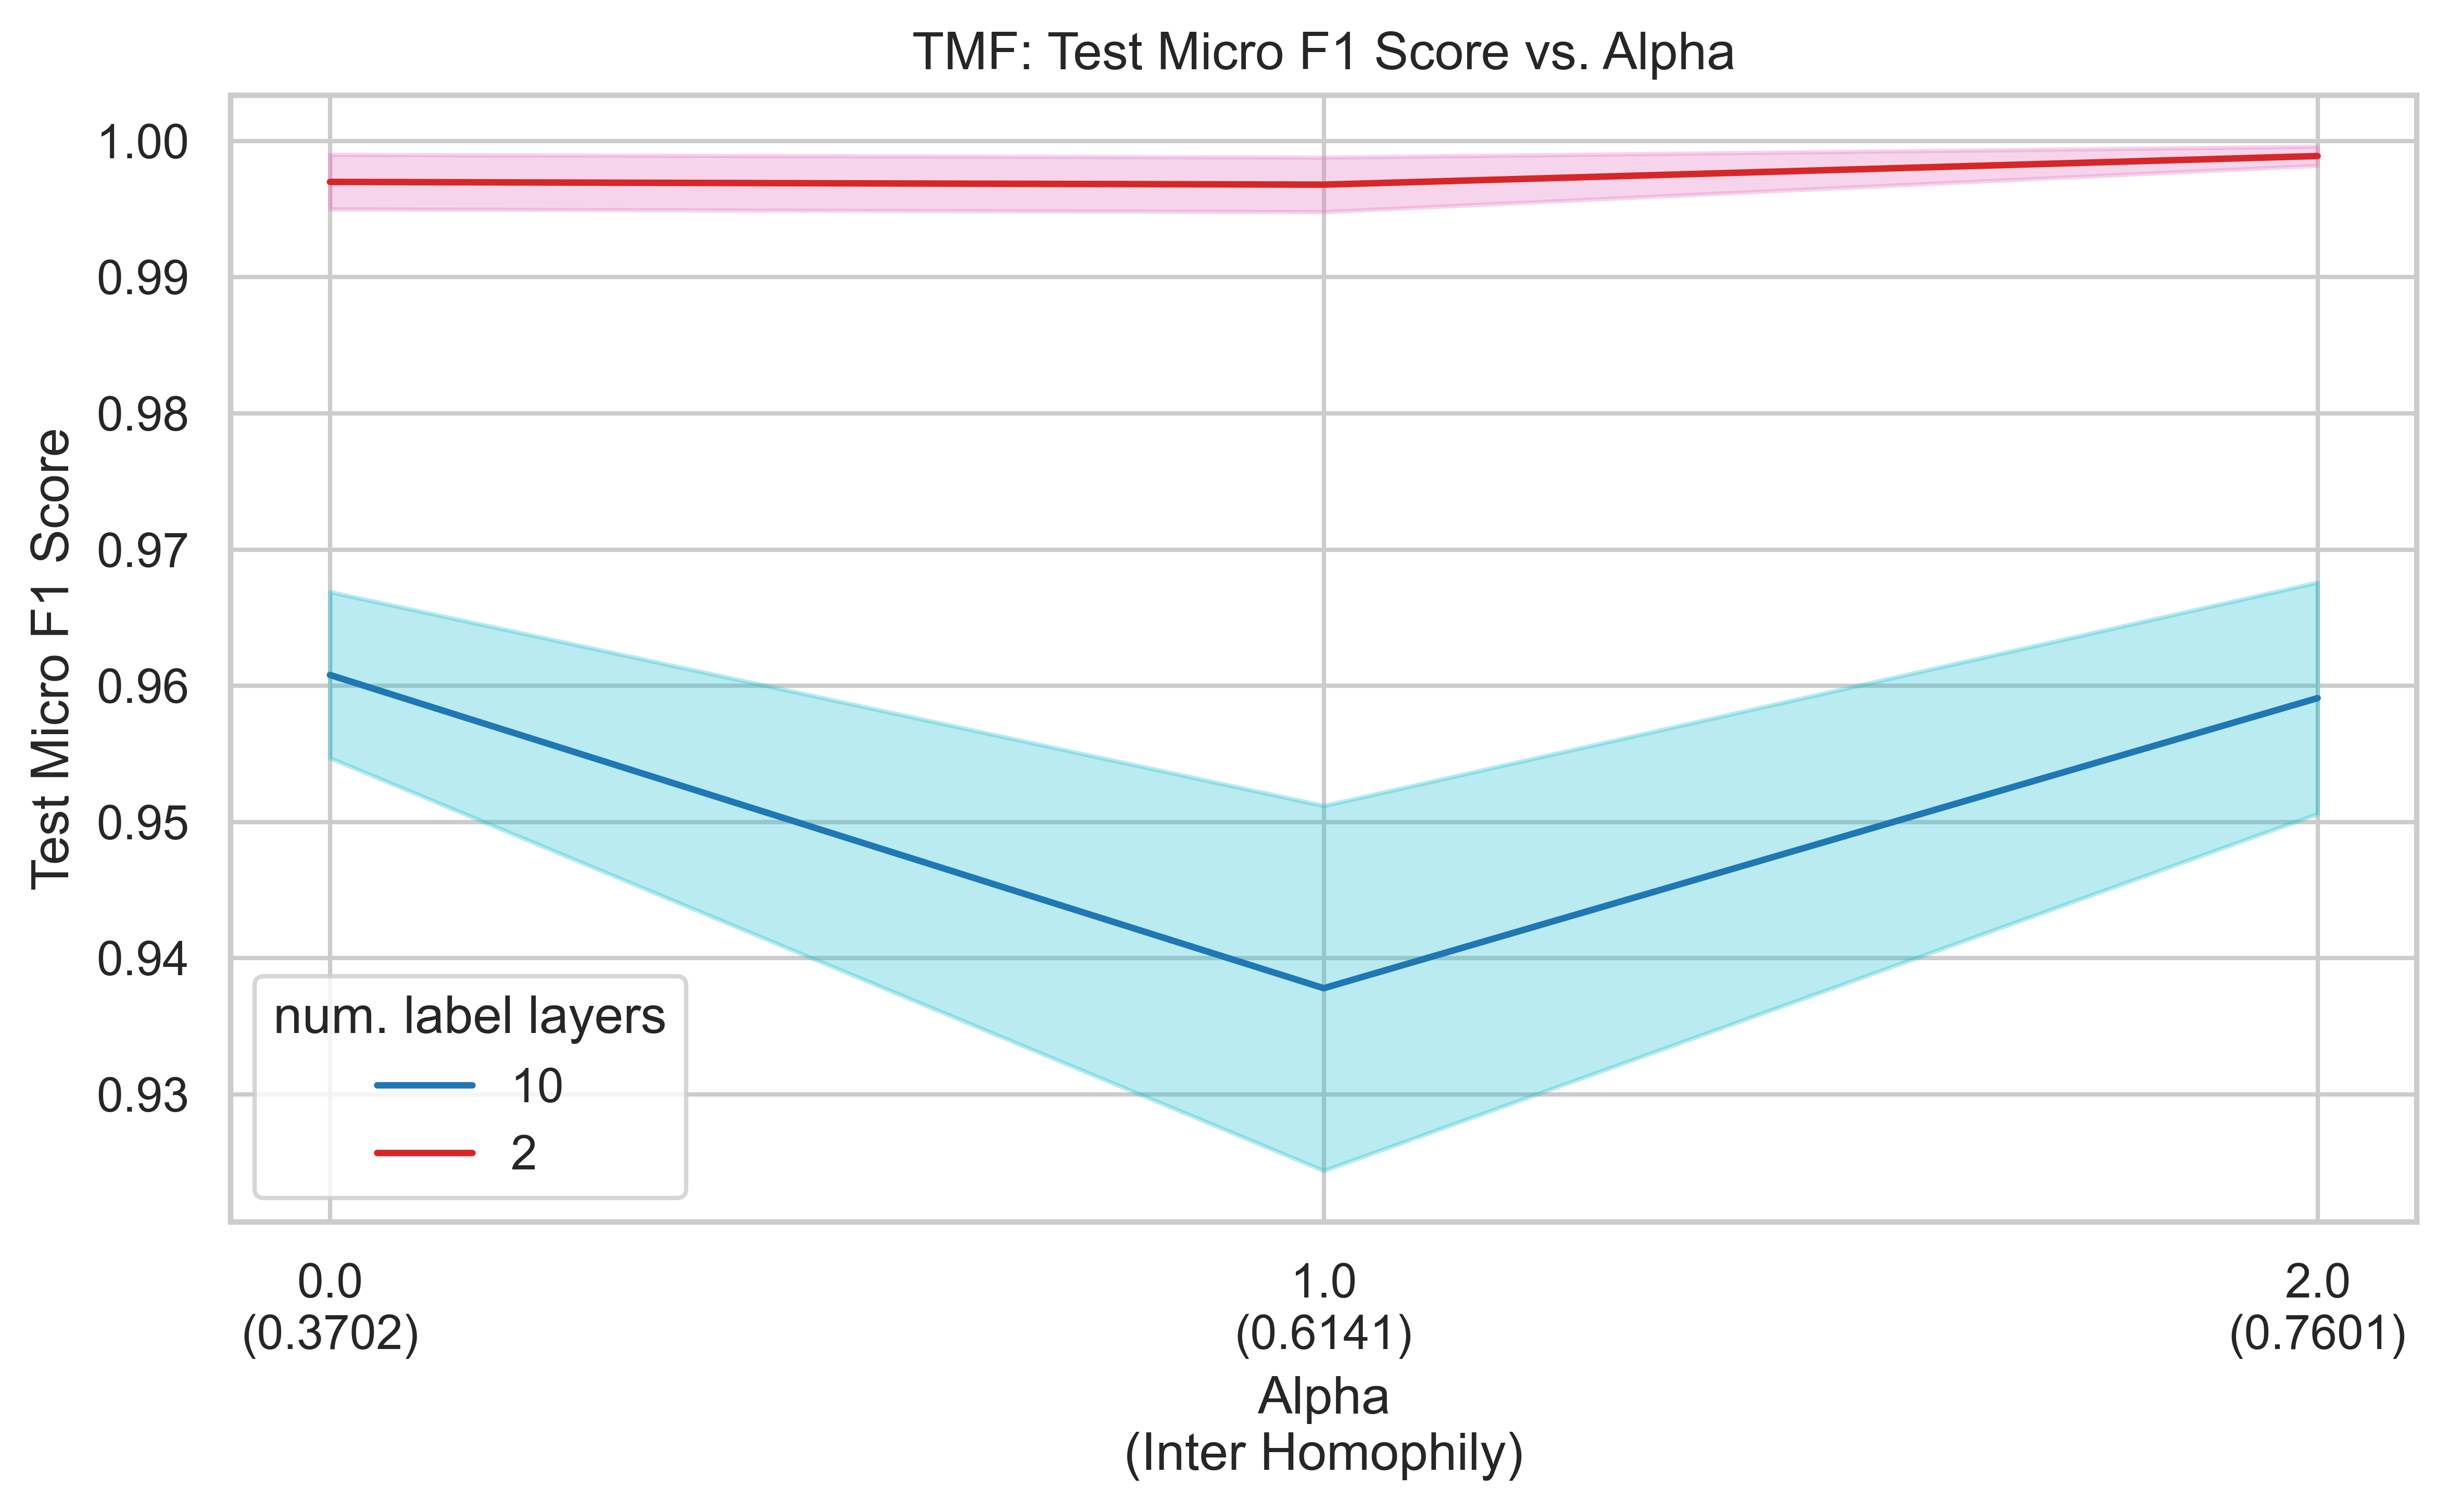

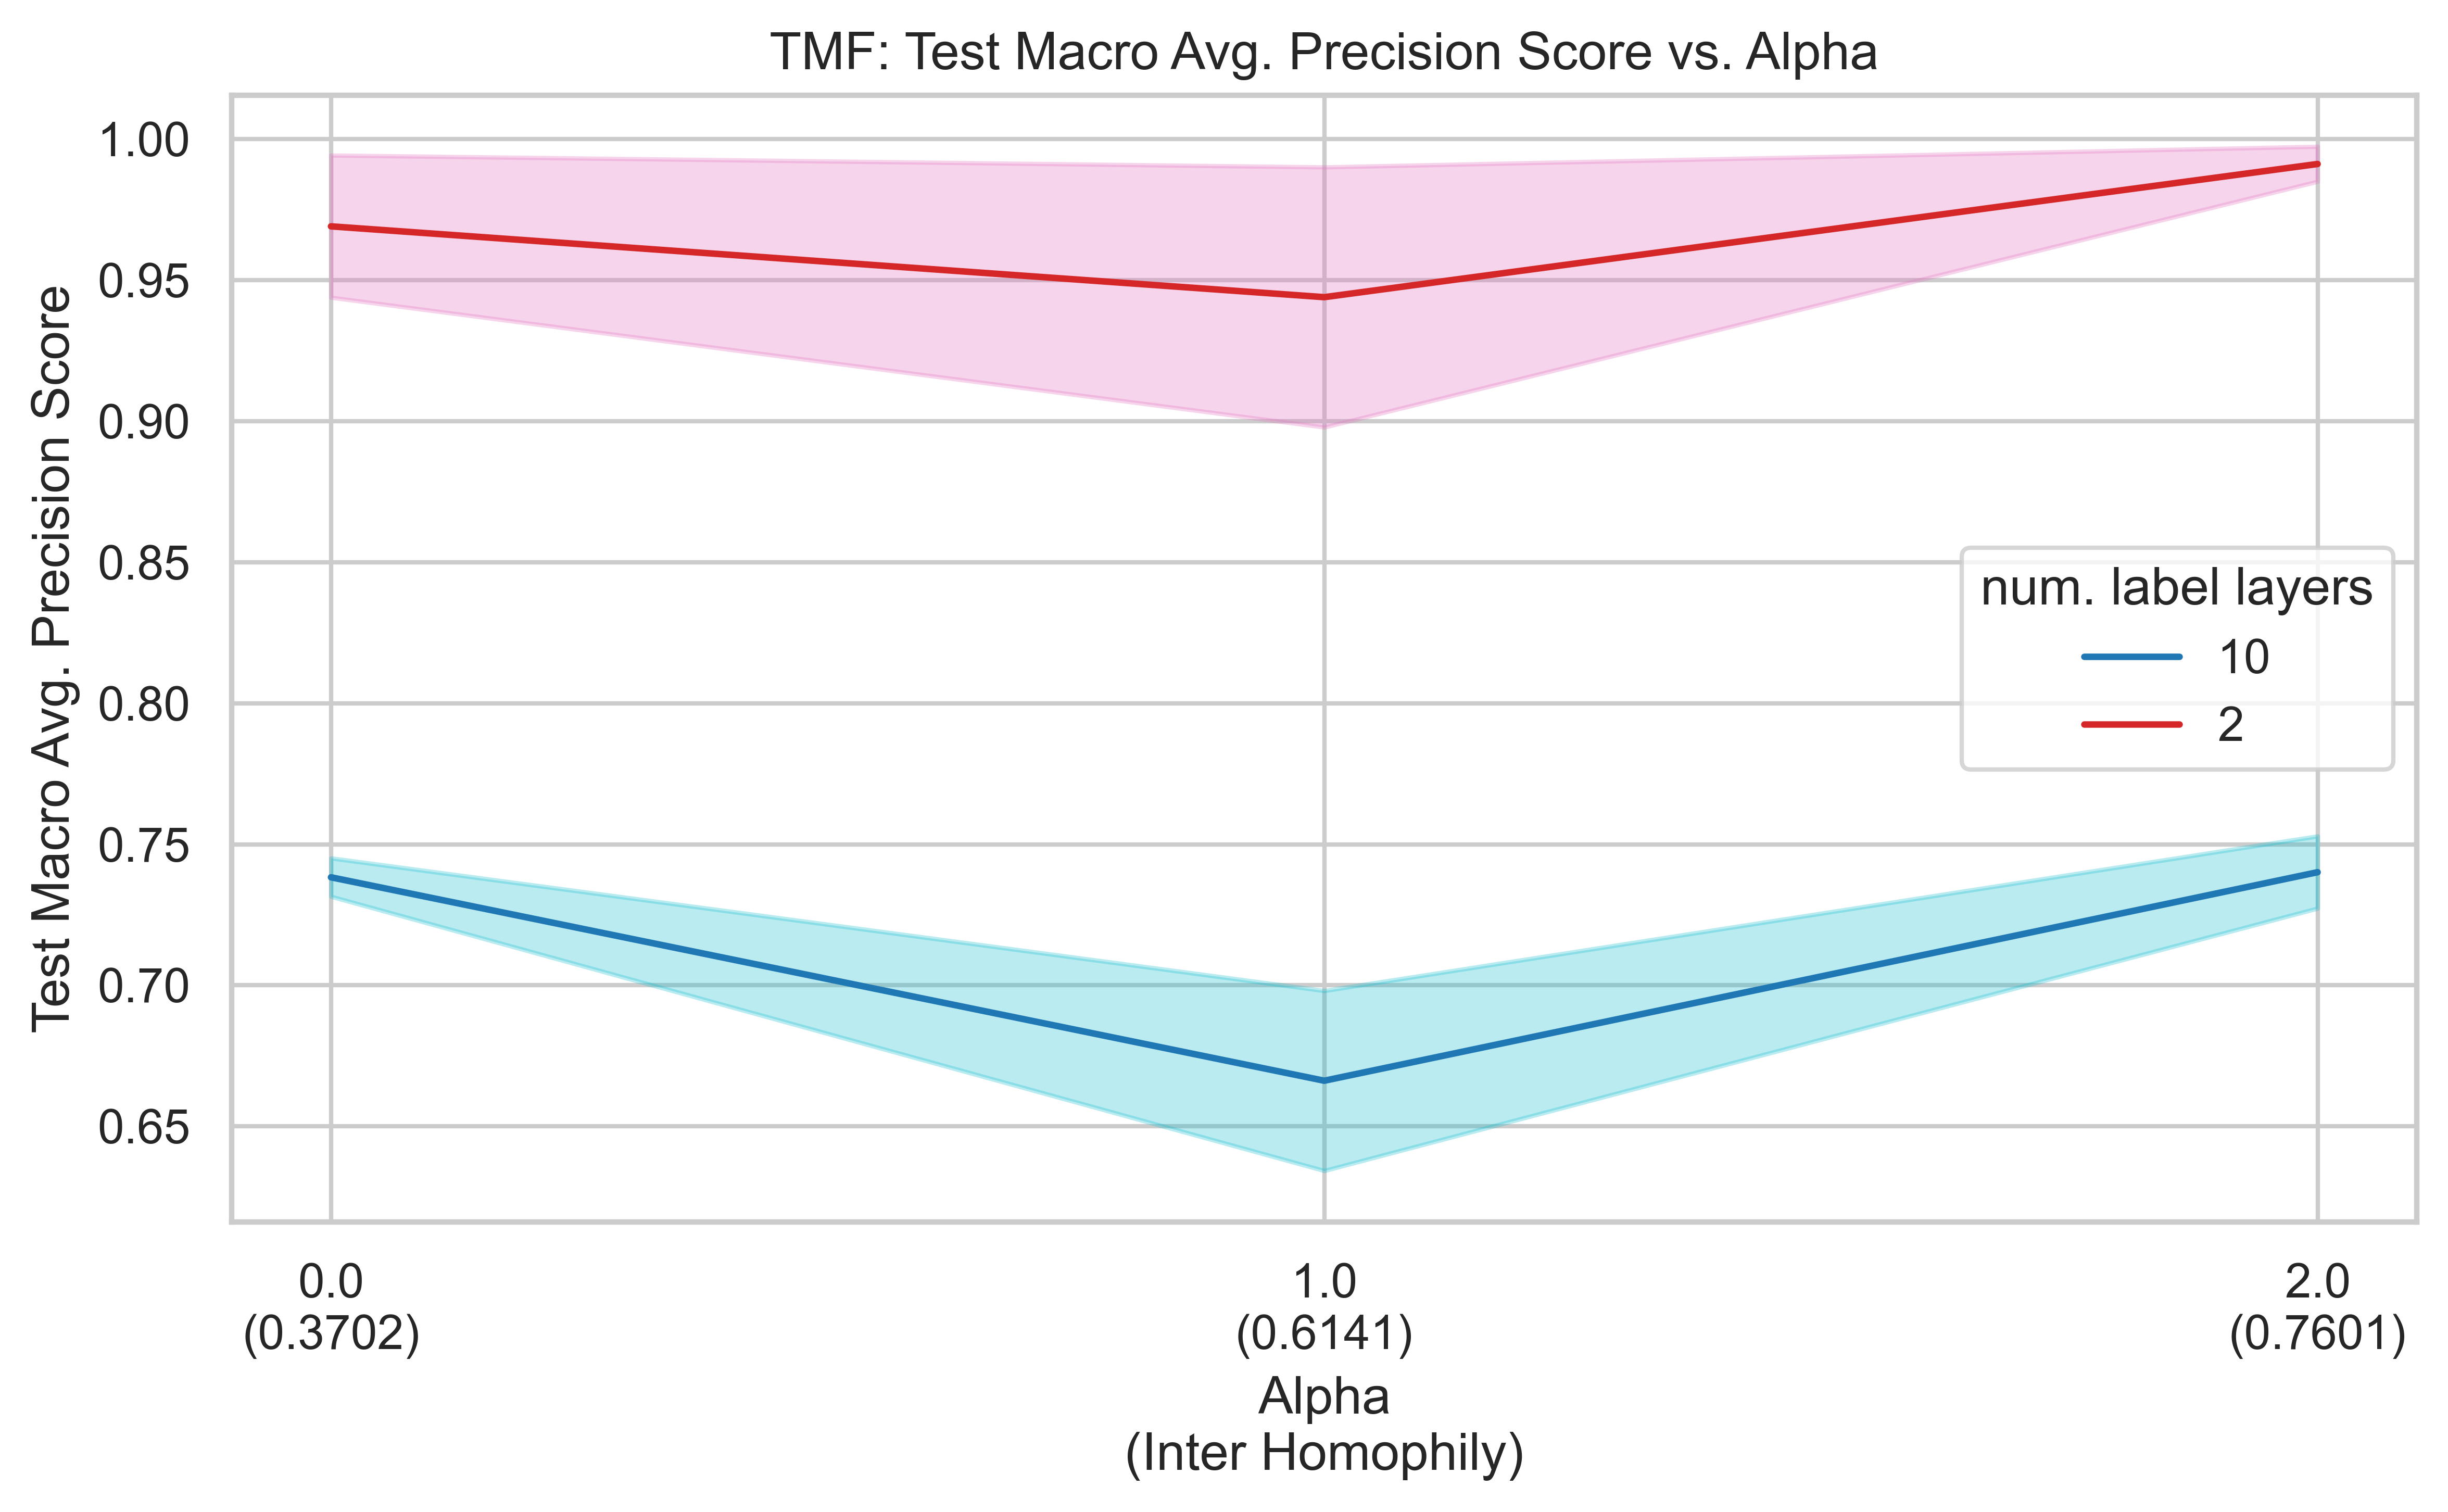

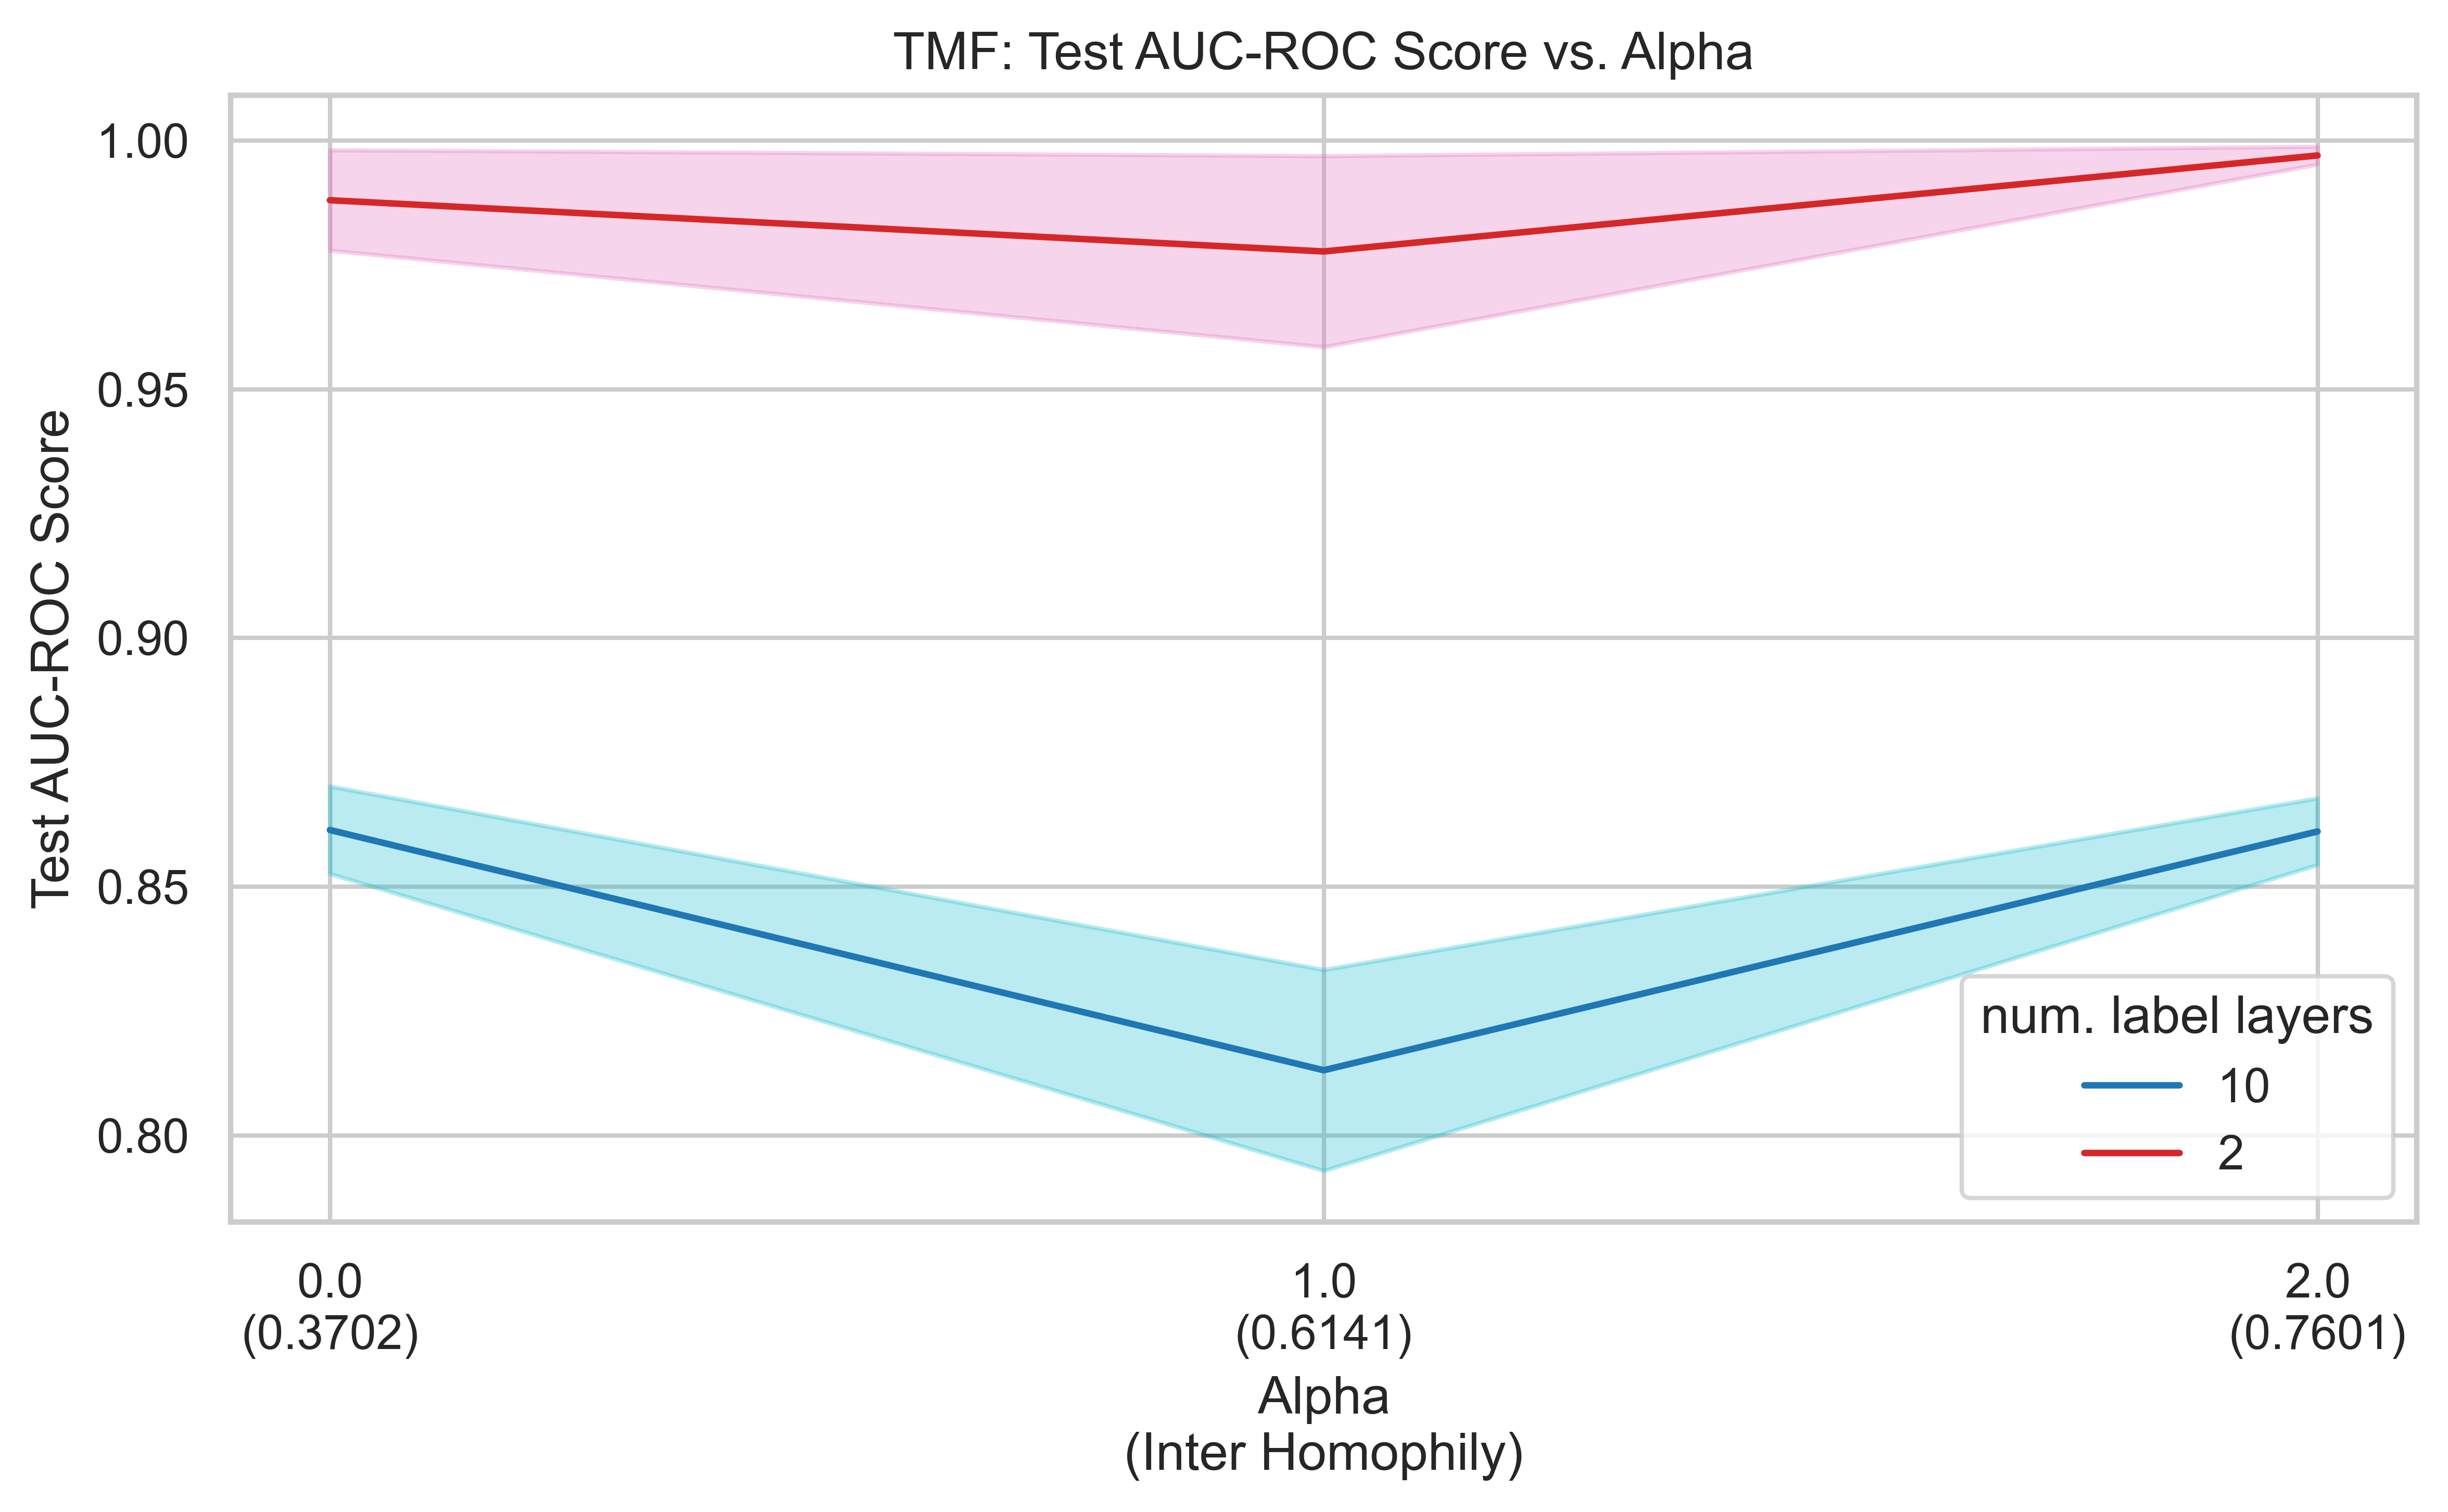

In [ ]:
metrics = [
    ("test_loss_mean", "test_loss_std", "Test BCE Loss"),
    ("test_f1_macro_mean", "test_f1_macro_std", "Test Macro F1 Score"),
    ("test_f1_micro_mean", "test_f1_micro_std", 'Test Micro F1 Score'),
    ("test_ap_macro_mean", "test_ap_macro_std", "Test Macro Avg. Precision Score"),
    ("test_auc_roc_mean", "test_auc_roc_std", "Test AUC-ROC Score"),
]

# Set style
sns.set(style="whitegrid")
colors = [("tab:blue", "tab:cyan"), ("tab:red","tab:pink"), ("tab:green", "tab:olive")]

# Create a plot for each metric
for mean_col, std_col, metric in metrics:
    plt.figure(figsize=(8, 5), dpi=600)
    
    for i, model in enumerate(df['num_label_layers'].unique()):
        subset = df[(df['num_label_layers'] == model) & (df['alpha'] <= 3)]
        # plt.errorbar(
        #     # subset["homophily"],
        #     subset["alpha"],
        #     subset[mean_col],
        #     yerr=subset[std_col],
        #     label=model,
        #     marker='o',
        #     capsize=4
        # )

        plt.plot(subset["alpha"], subset[mean_col], label=f'{model}', color=colors[i][0])
        plt.fill_between(subset["alpha"], subset[mean_col] - subset[std_col], subset[mean_col] + subset[std_col],
                         color=colors[i][1], alpha=0.3, label='_nolegend_')

    # Build custom tick labels
    unique_alphas = sorted(subset["alpha"].unique())
    ticks = unique_alphas
    tick_labels = [
        f"{alpha:.1f}\n({subset[subset['alpha'] == alpha]['homophily'].iloc[0]:.4f})"
        for alpha in ticks
    ]
    plt.xticks(ticks, tick_labels)

    # plt.title(f"{mean_col.replace('_mean', '').replace('_', ' ').title()} vs. Homophily")
    plt.title(f"TMF: {metric} vs. Alpha")
    # plt.xlabel("Homophily")
    plt.xlabel("Alpha\n(Inter Homophily)")
    plt.ylabel(metric)
    plt.legend(title="num. label layers")
    # plt.xscale("log")
    plt.tight_layout()
    plt.show()

In [15]:
def load4(filepath):
    # Load text file
    with open(filepath, "r") as file:
        text = file.read()
        # print(text)

    # Extract homophily
    homophily_match = re.search(r'Dataset Inter Homophily:\s*([\d.]+)', text)
    homophily = float(homophily_match.group(1)) if homophily_match else None

    # Extract alpha
    alpha_match = re.search(r"'ALPHA':\s*([\d.]+)", text)
    alpha = float(alpha_match.group(1)) if alpha_match else None

    # Prepare list to hold parsed entries
    data = []

    # Split into blocks per model
    blocks = text.split("\n\n")
    for block in blocks:
        lines = block.strip().splitlines()
        if len(lines) == 0:
            continue
        
        # First line is model name, try to match:
        header_match = re.match(r'(.+?):\s*$', lines[0])
        if not header_match:
            continue  # skip blocks that are not a model
        
        model_name = header_match.group(1).strip()
        
        # Dict to hold this model entry
        entry = {
            "model_name": model_name,
            "homophily": homophily,
            "alpha": alpha
        }
        
        # Now parse each metric line
        for line in lines[1:]:
            metric_match = re.match(r'([\w\- ]+):\s*([\d.]+)\+\-([\d.]+)', line)
            if metric_match:
                metric_name = metric_match.group(1).strip().lower().replace("-", "_").replace(" ", "_")
                mean_val = float(metric_match.group(2))
                std_val = float(metric_match.group(3))
                entry[f"{metric_name}_mean"] = mean_val
                entry[f"{metric_name}_std"] = std_val
        
        data.append(entry)

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Convert all numeric columns to float (just in case)
    for col in df.columns:
        if col != "model_name":
            df[col] = pd.to_numeric(df[col], errors='ignore')
        
    return df

In [17]:
filepaths = ['data\\experiment5\\results_alpha0.txt',
             'data\\experiment5\\results_alpha1.txt',
             'data\\experiment5\\results_alpha2.txt',
            ]

df = pd.concat([load4(filepath) for filepath in filepaths], axis=0)
df

C:\Users\formo\AppData\Local\Temp\ipykernel_21676\3478229421.py:57: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


model_name  homophily  alpha  test_loss_mean  test_loss_std  \
0     Temporal MultiFix     0.3702    0.0          0.0232         0.0122   
1  Temporal MultiFix DW     0.3702    0.0          0.0272         0.0135   
0     Temporal MultiFix     0.6139    1.0          0.0253         0.0131   
1  Temporal MultiFix DW     0.6139    1.0          0.0293         0.0125   
0     Temporal MultiFix     0.7600    2.0          0.0207         0.0096   
1  Temporal MultiFix DW     0.7600    2.0          0.0442         0.0162   

   test_f1_macro_mean  test_f1_macro_std  test_f1_micro_mean  \
0              0.9755             0.0197              0.9974   
1              0.9684             0.0238              0.9958   
0              0.9764             0.0201              0.9964   
1              0.9705             0.0195              0.9945   
0              0.9906             0.0059              0.9983   
1              0.9362             0.0459              0.9907   

   test_f1_micro_std  test_ap_macro_mean  test_ap_macro_std  \
0             0.0018              0.9613             0.0295   
1             0.0029              0.9464             0.0390   
0             0.0026              0.9593             0.0341   
1             0.0040              0.9482             0.0327   
0             0.0009              0.9826             0.0108   
1             0.0057              0.9053             0.0610   

   test_auc_roc_mean  test_auc_roc_std  
0             0.9850            0.0121  
1             0.9786            0.0152  
0             0.9844            0.0130  
1             0.9920            0.0062  
0             0.9955            0.0021  
1             0.9704            0.0214

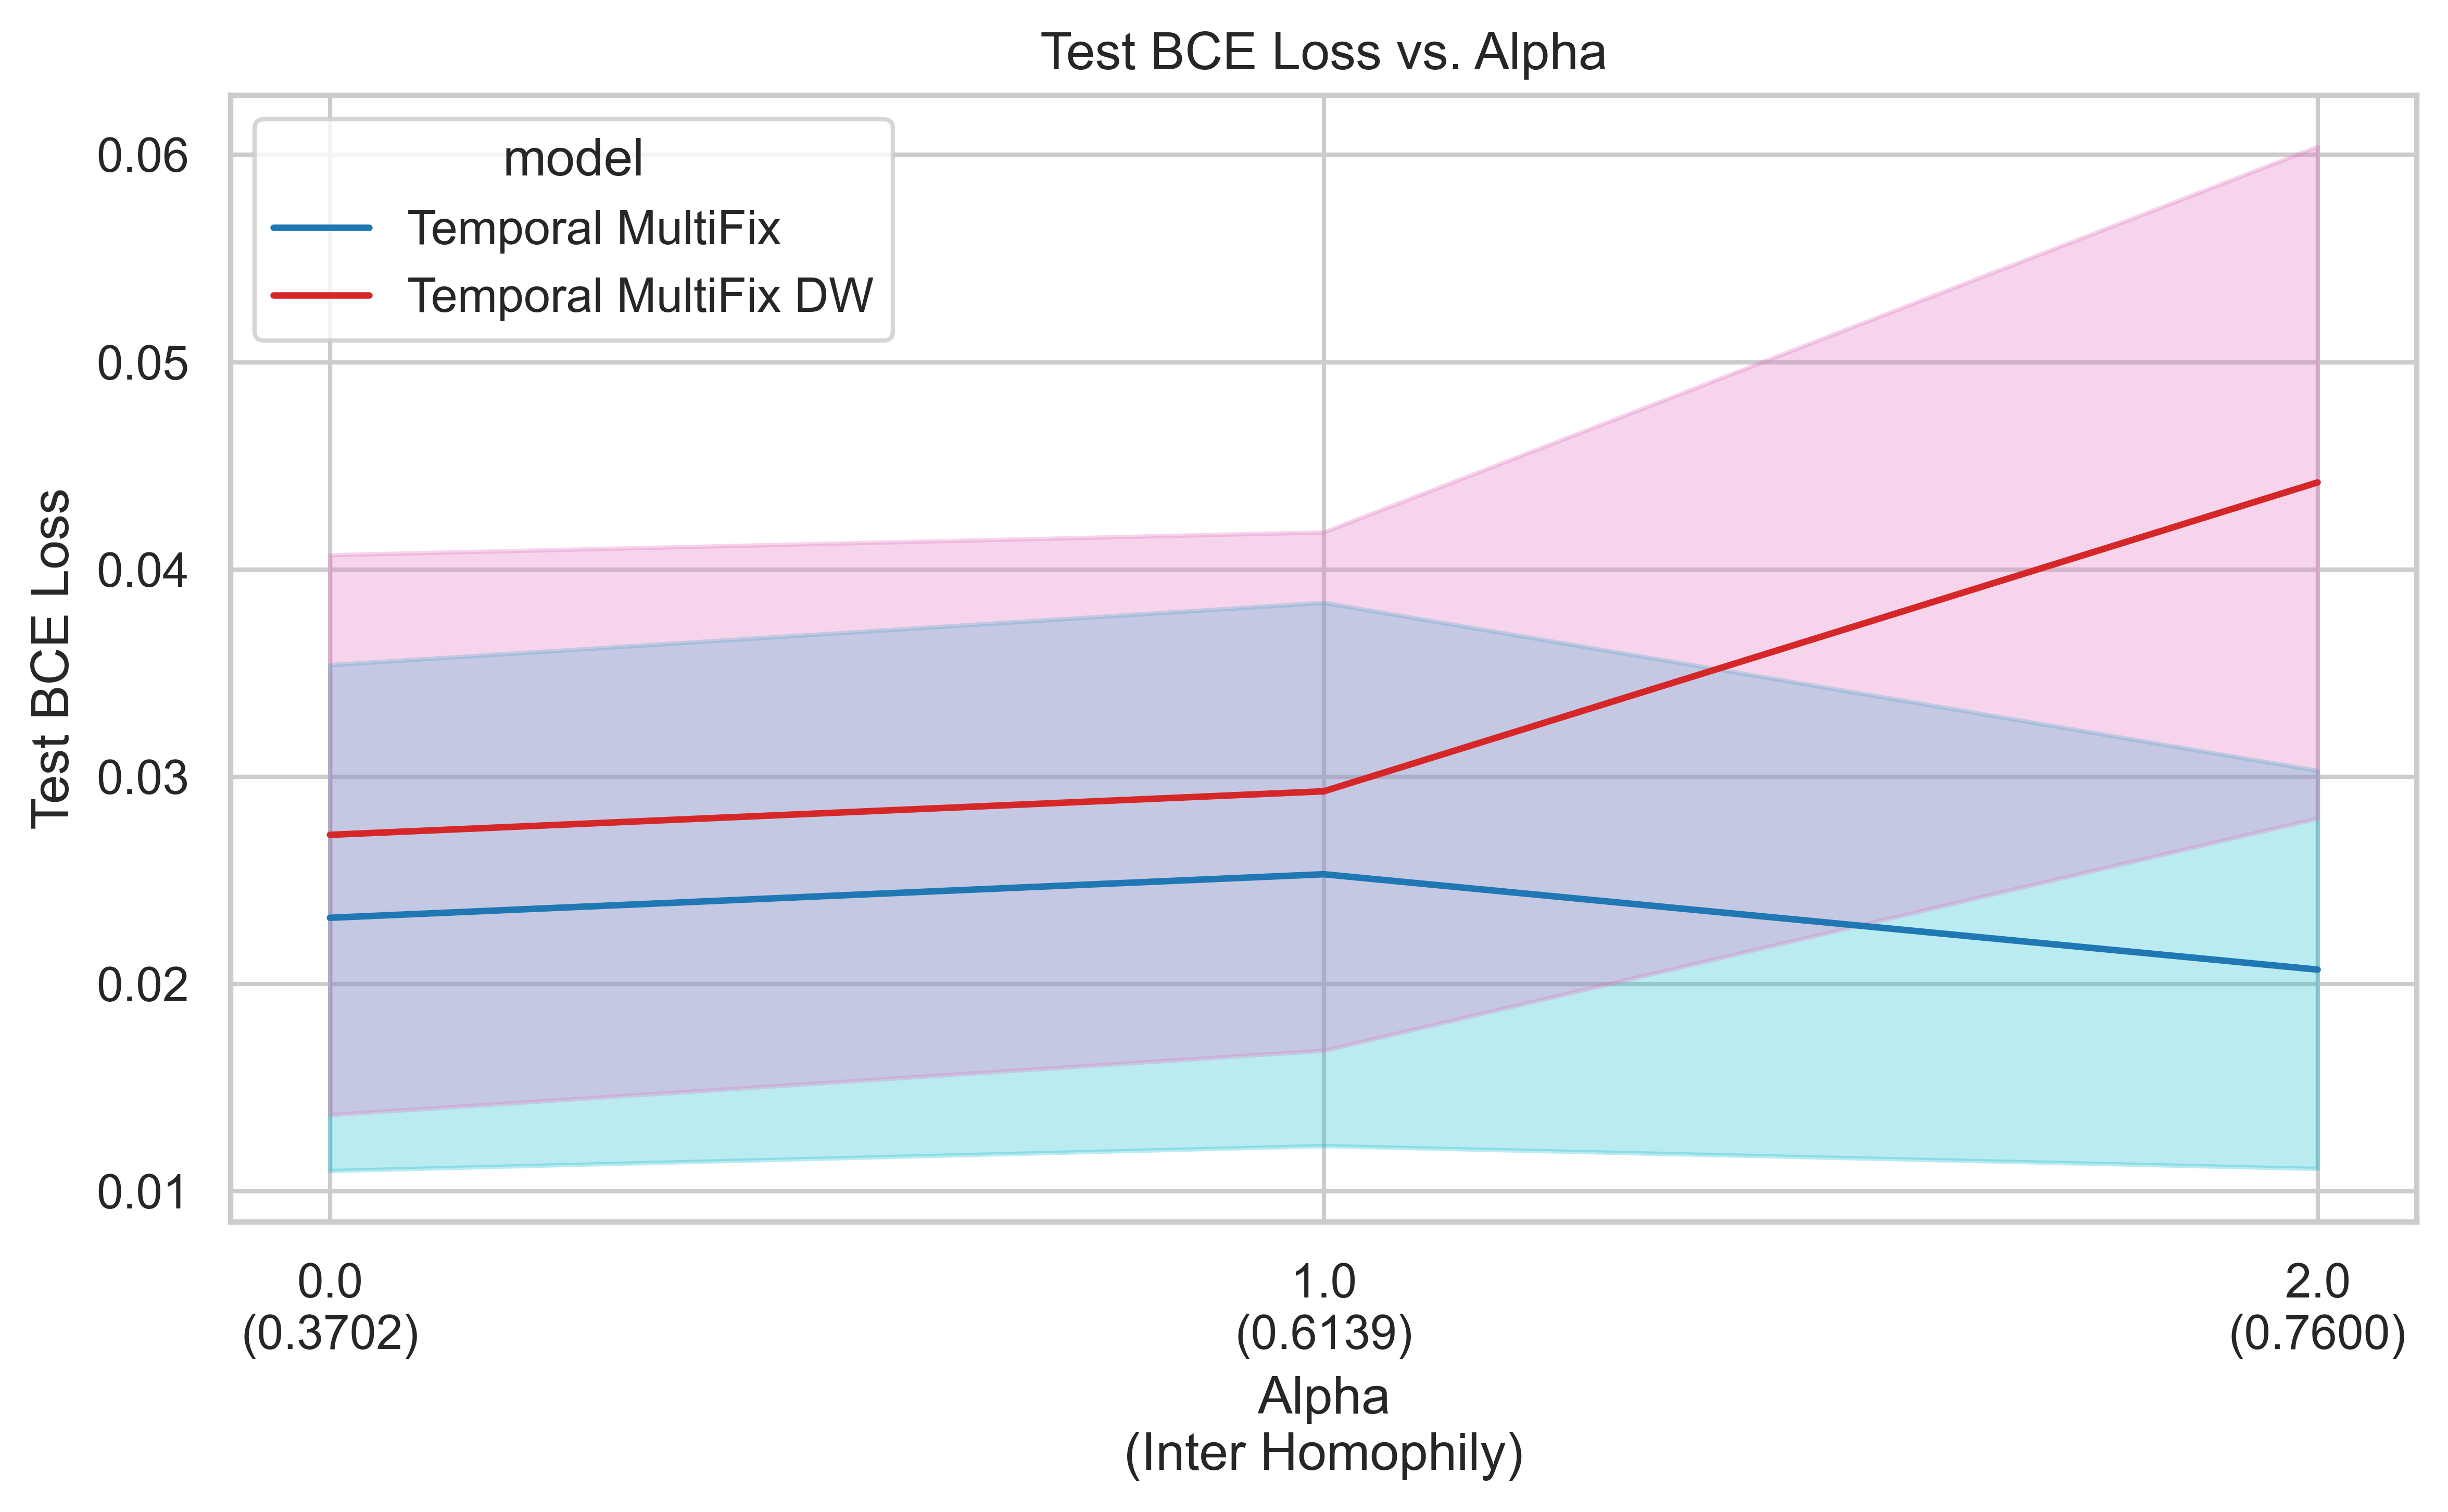

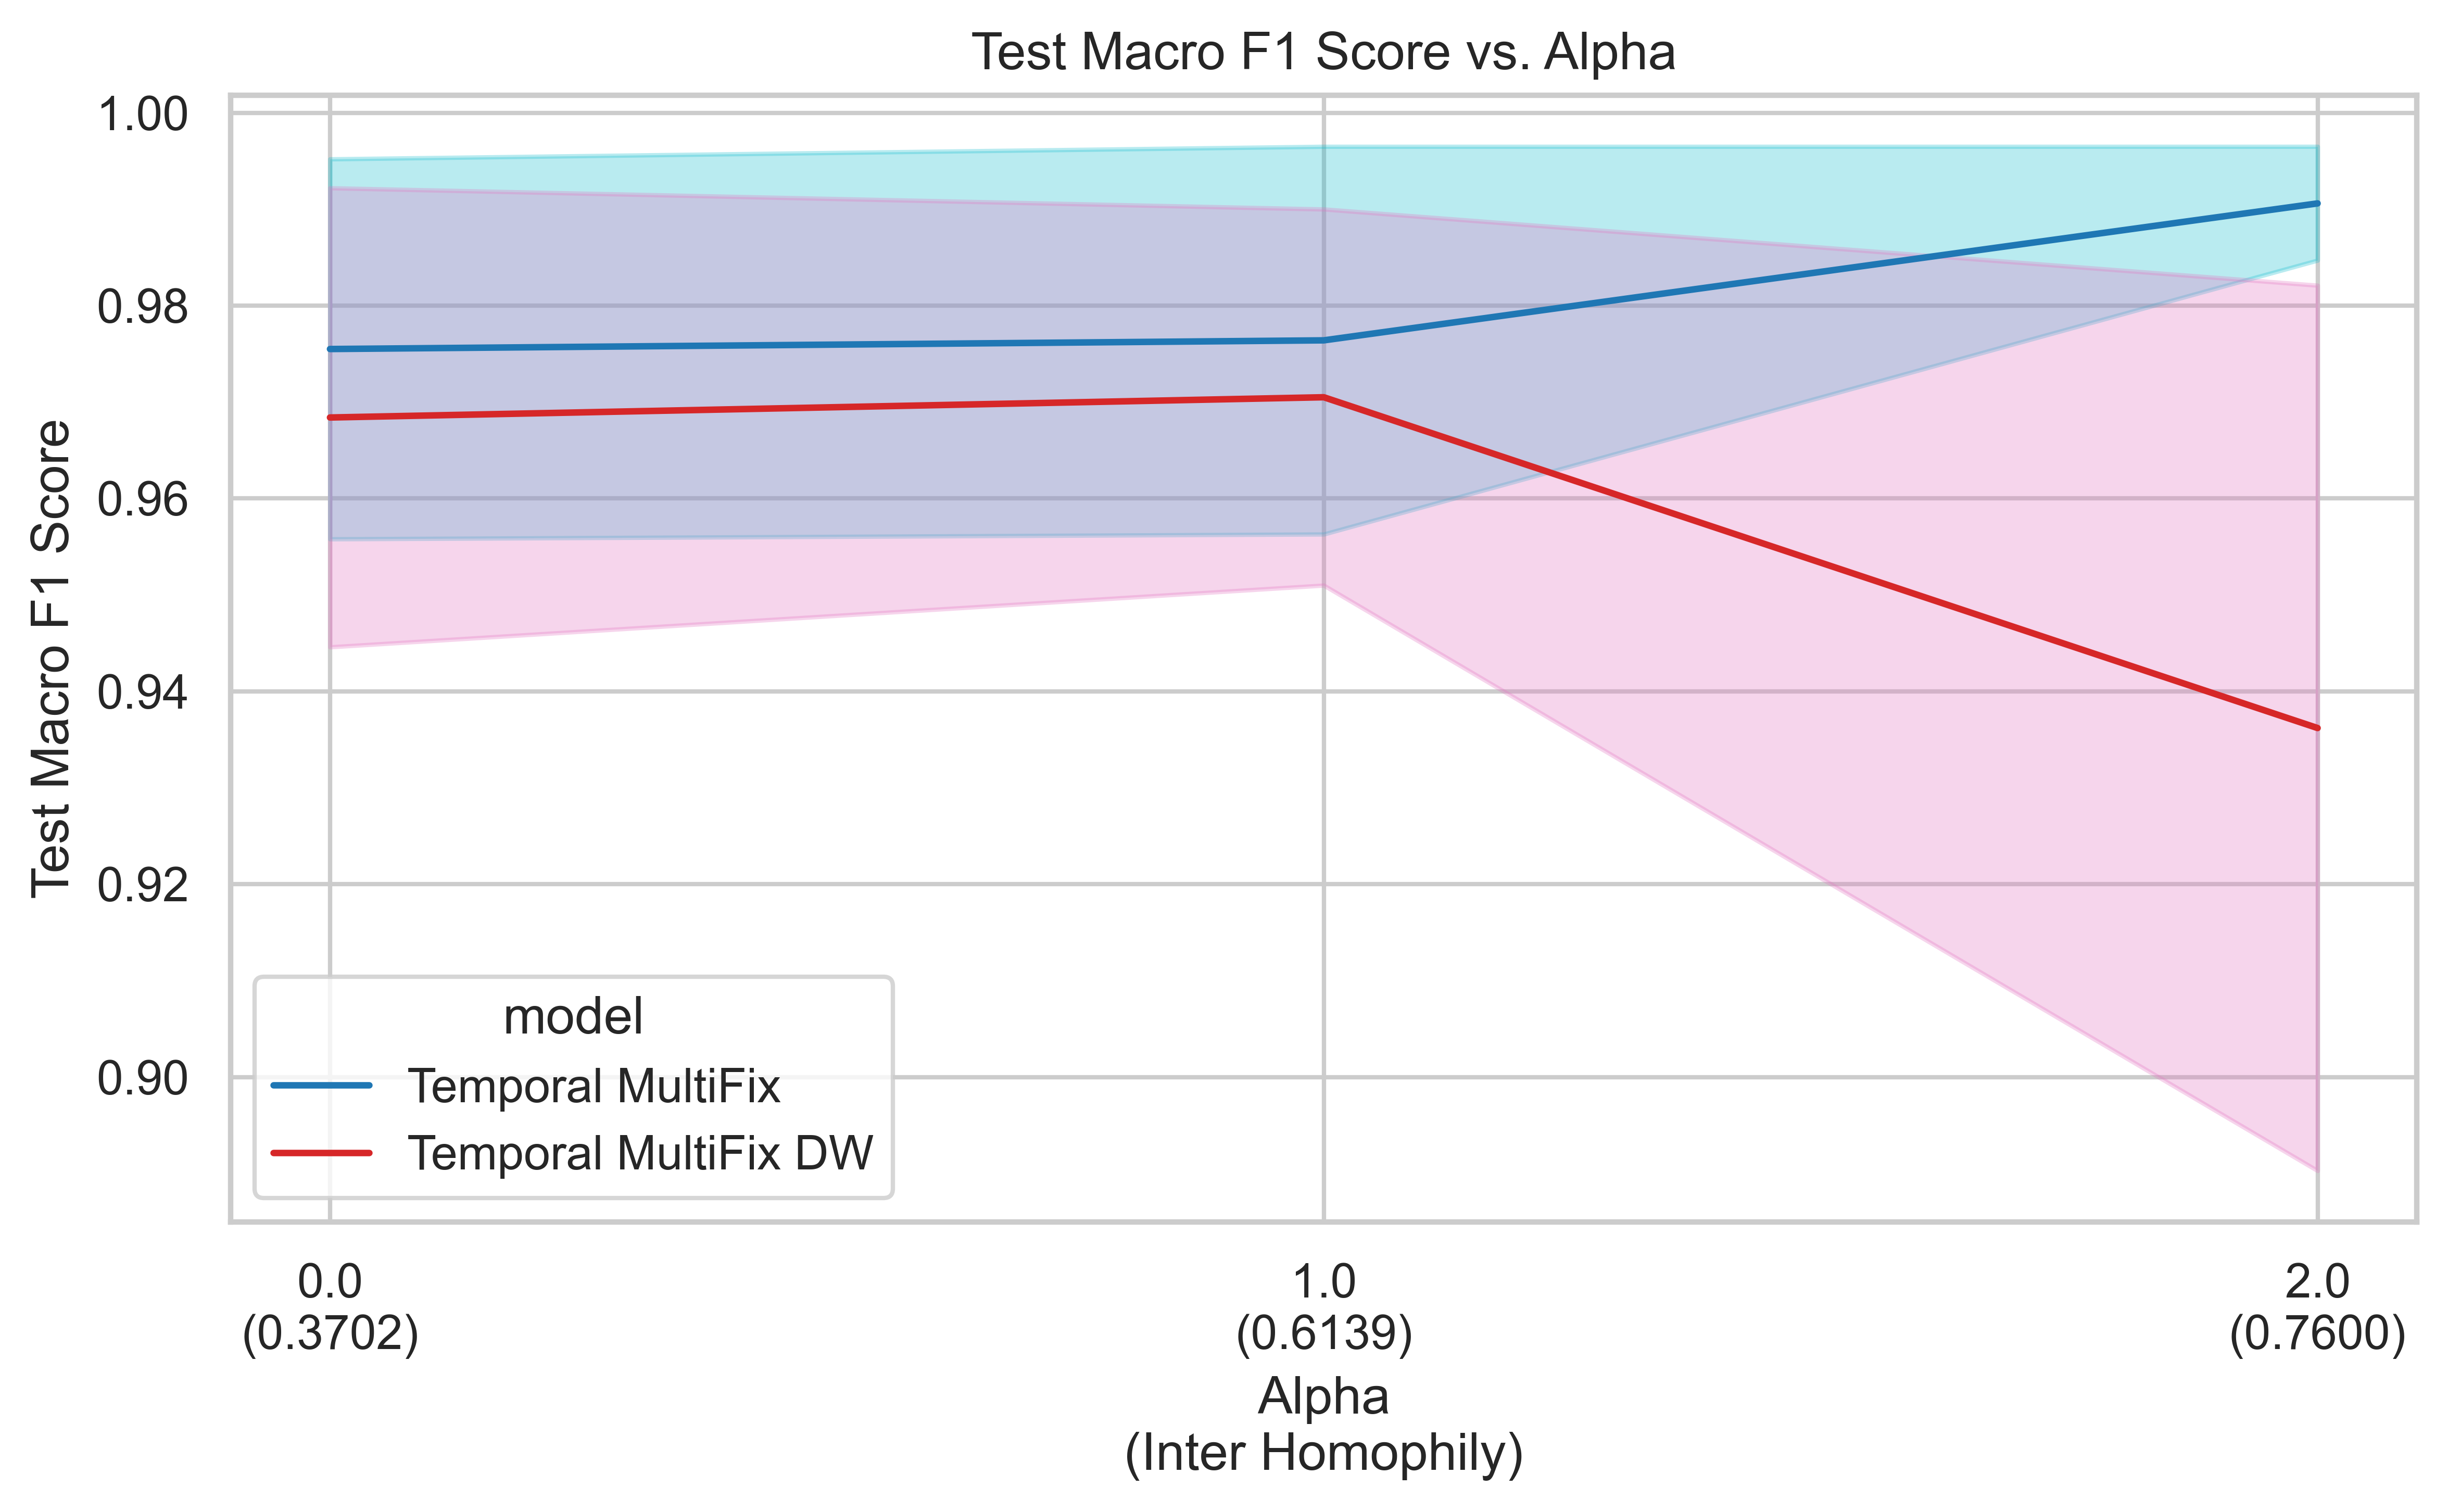

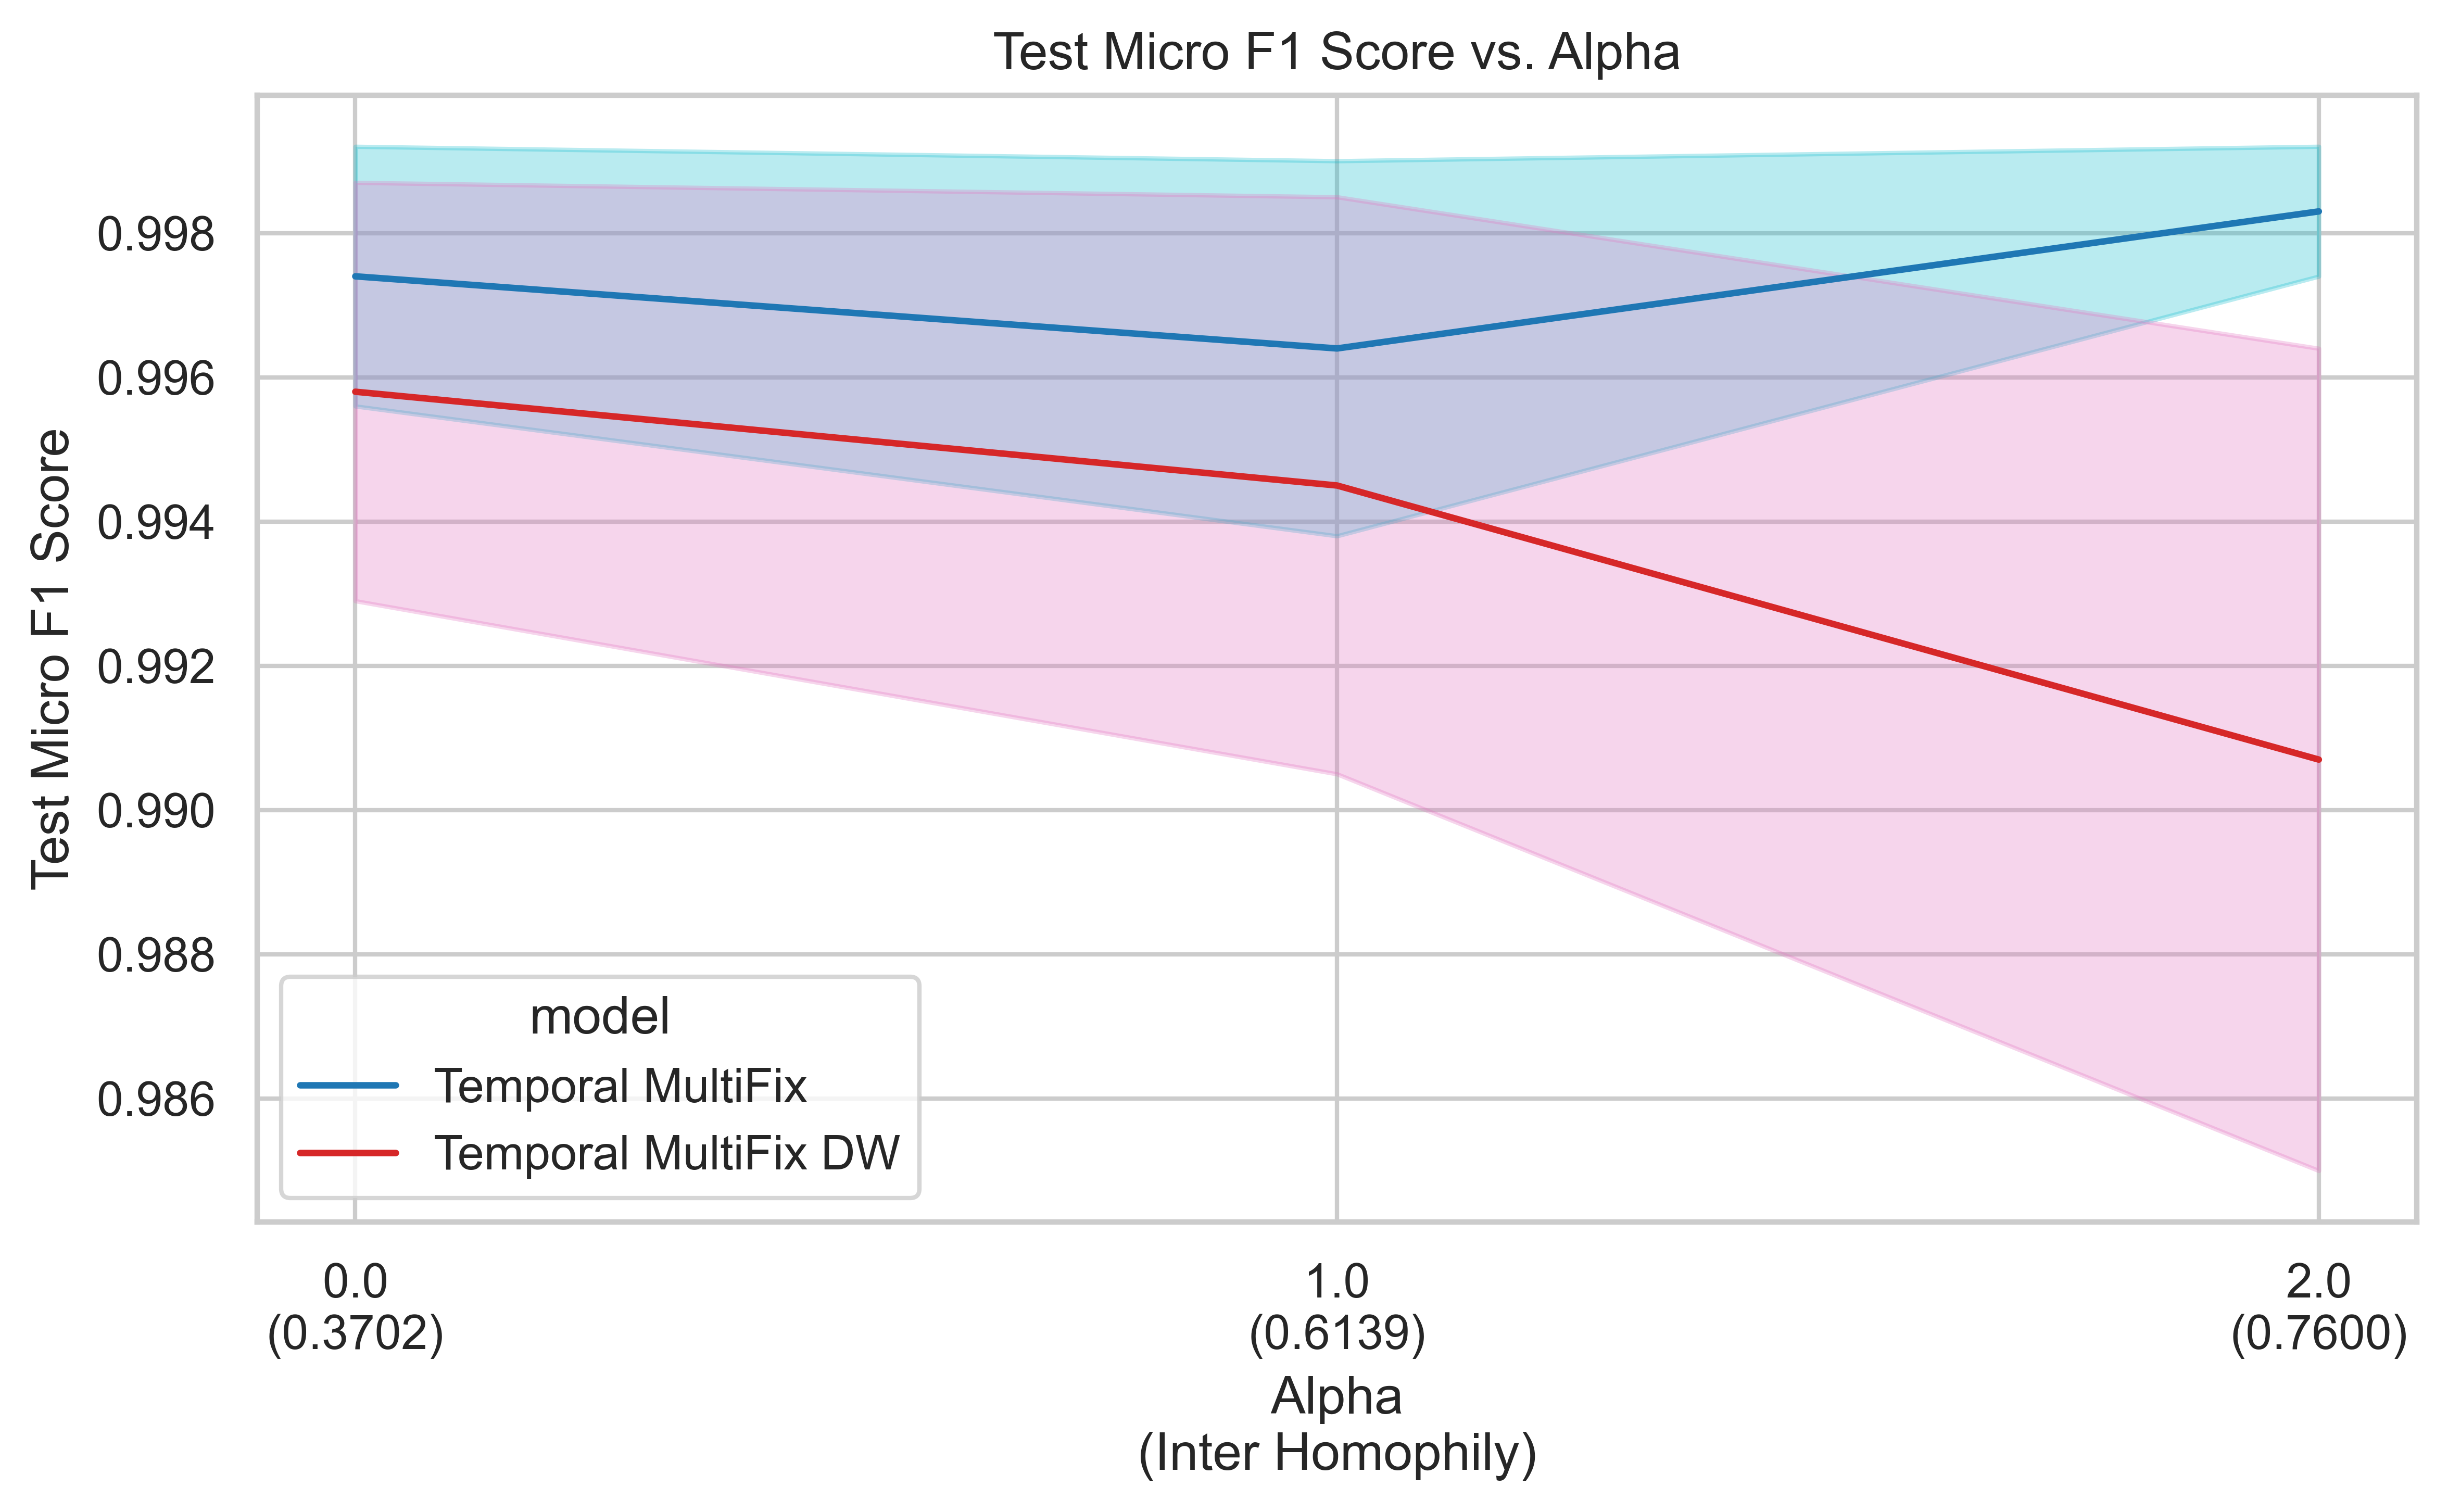

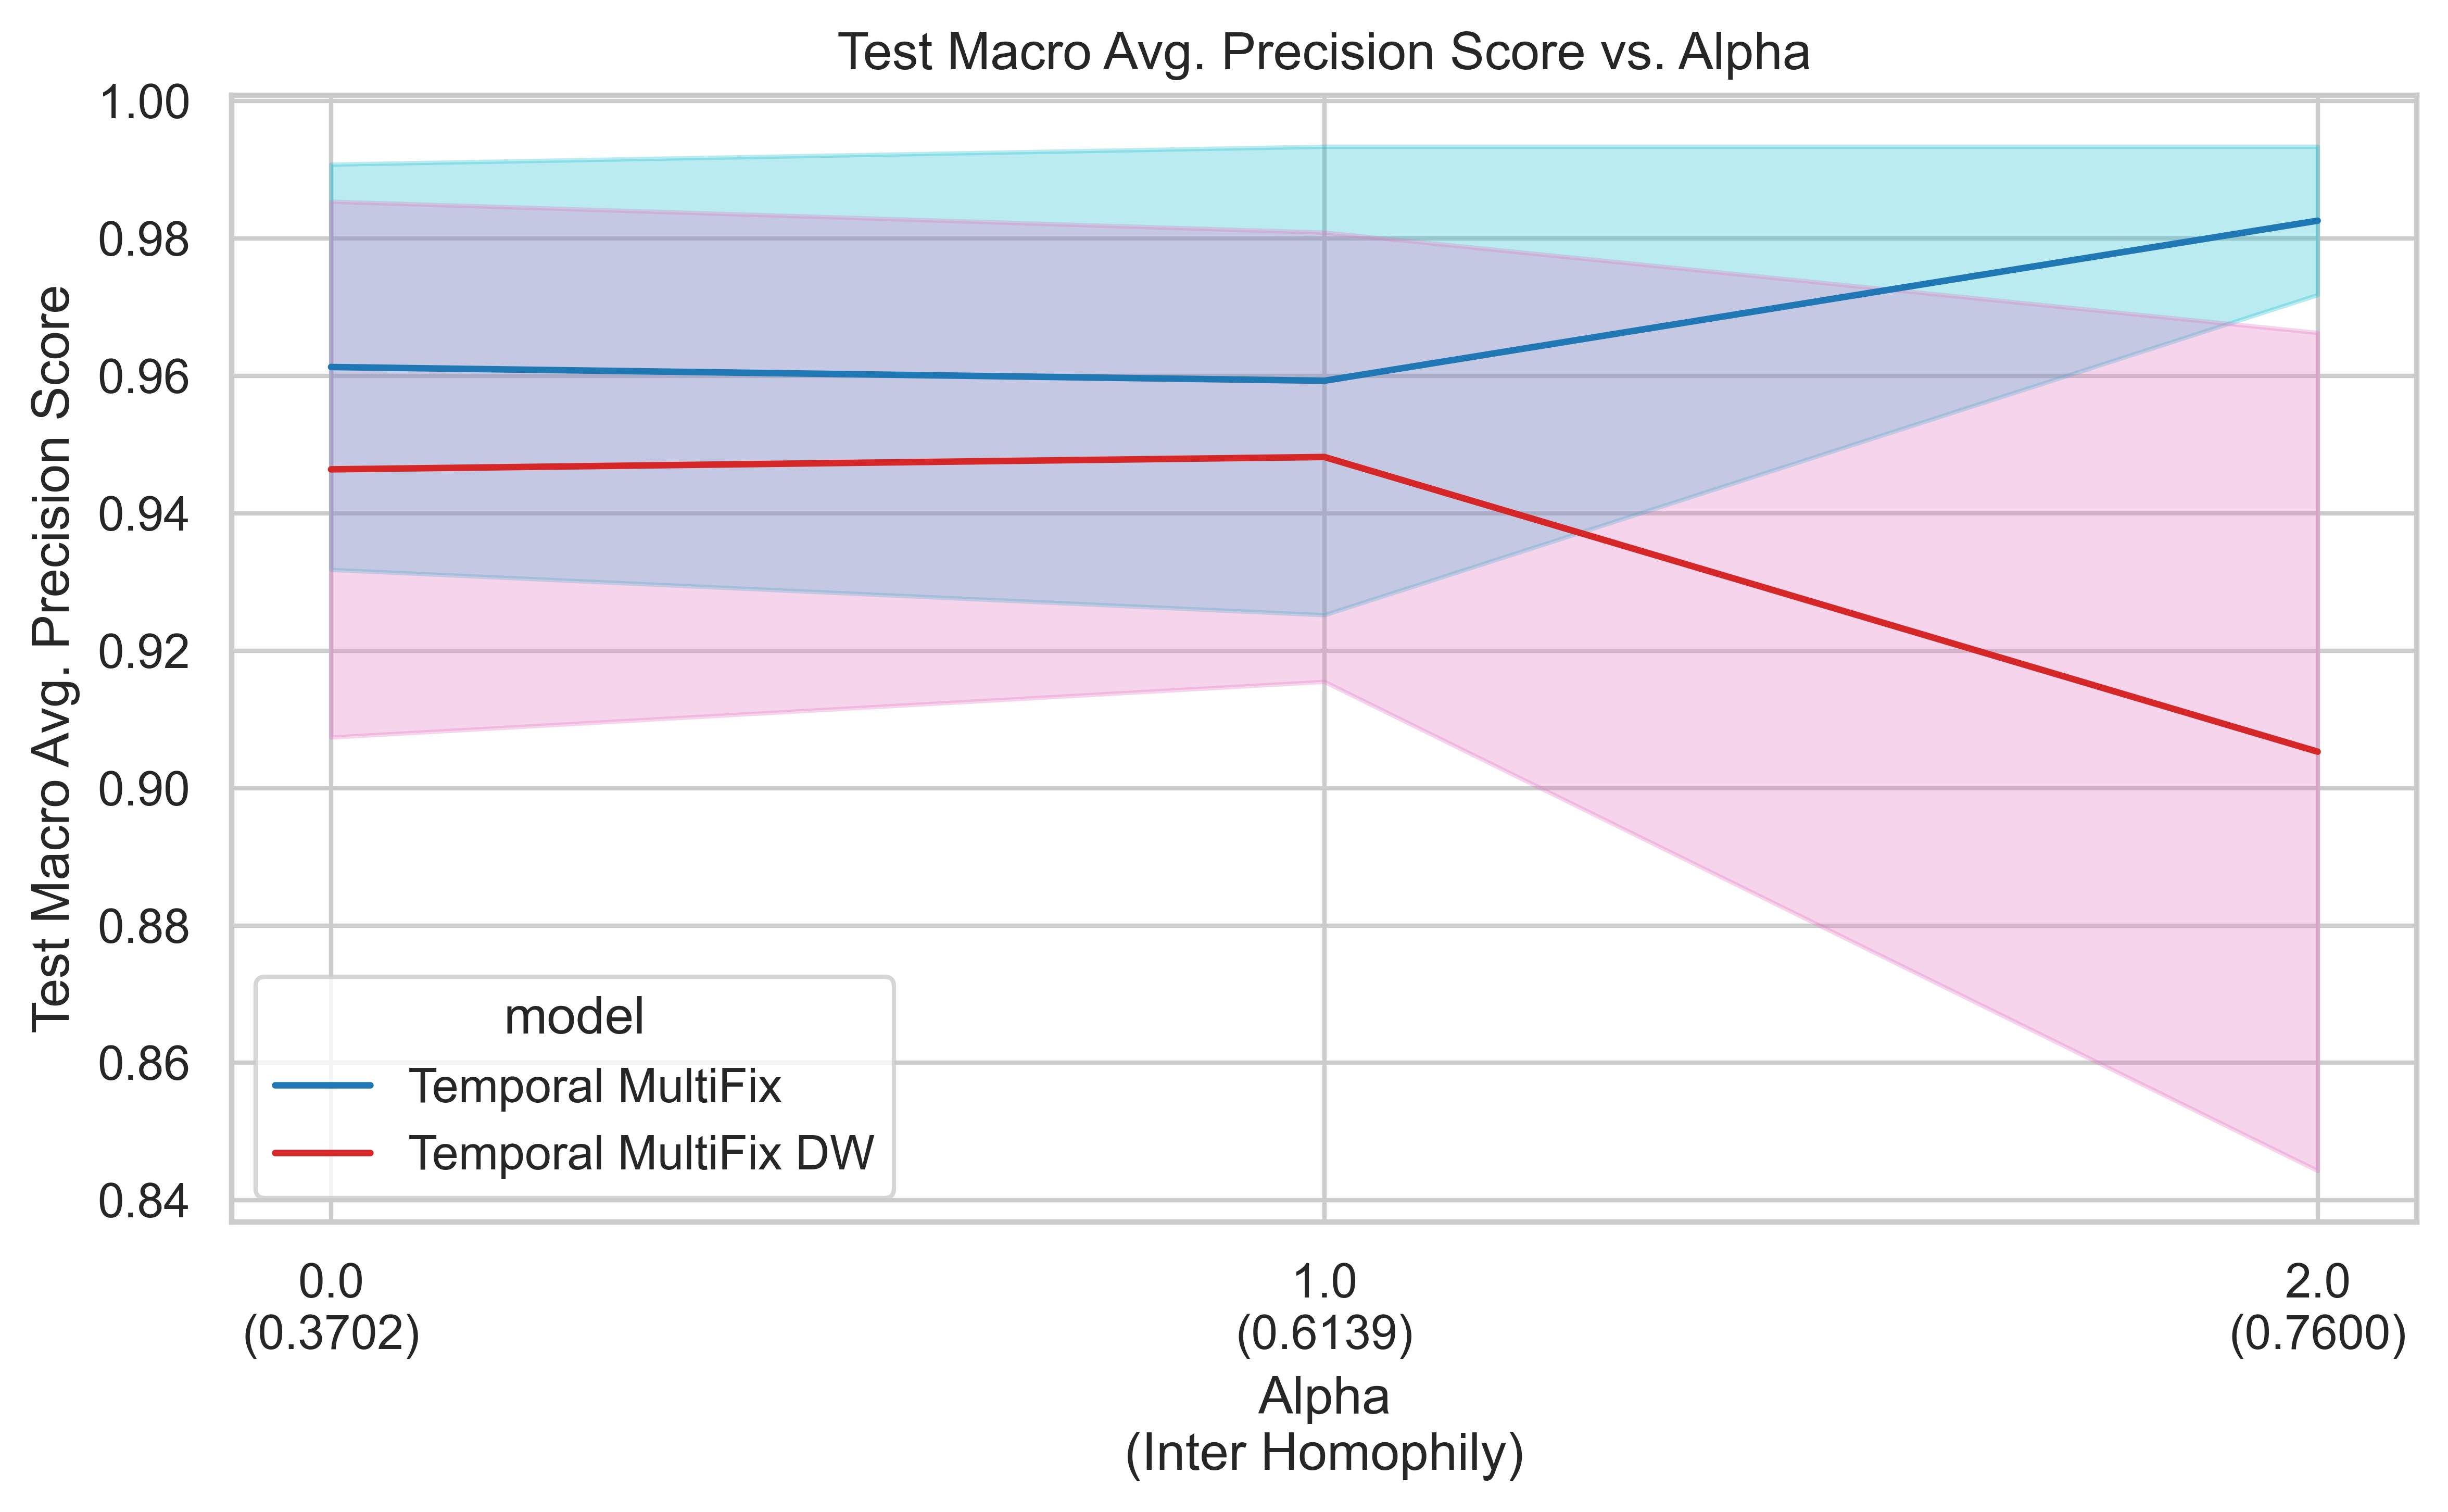

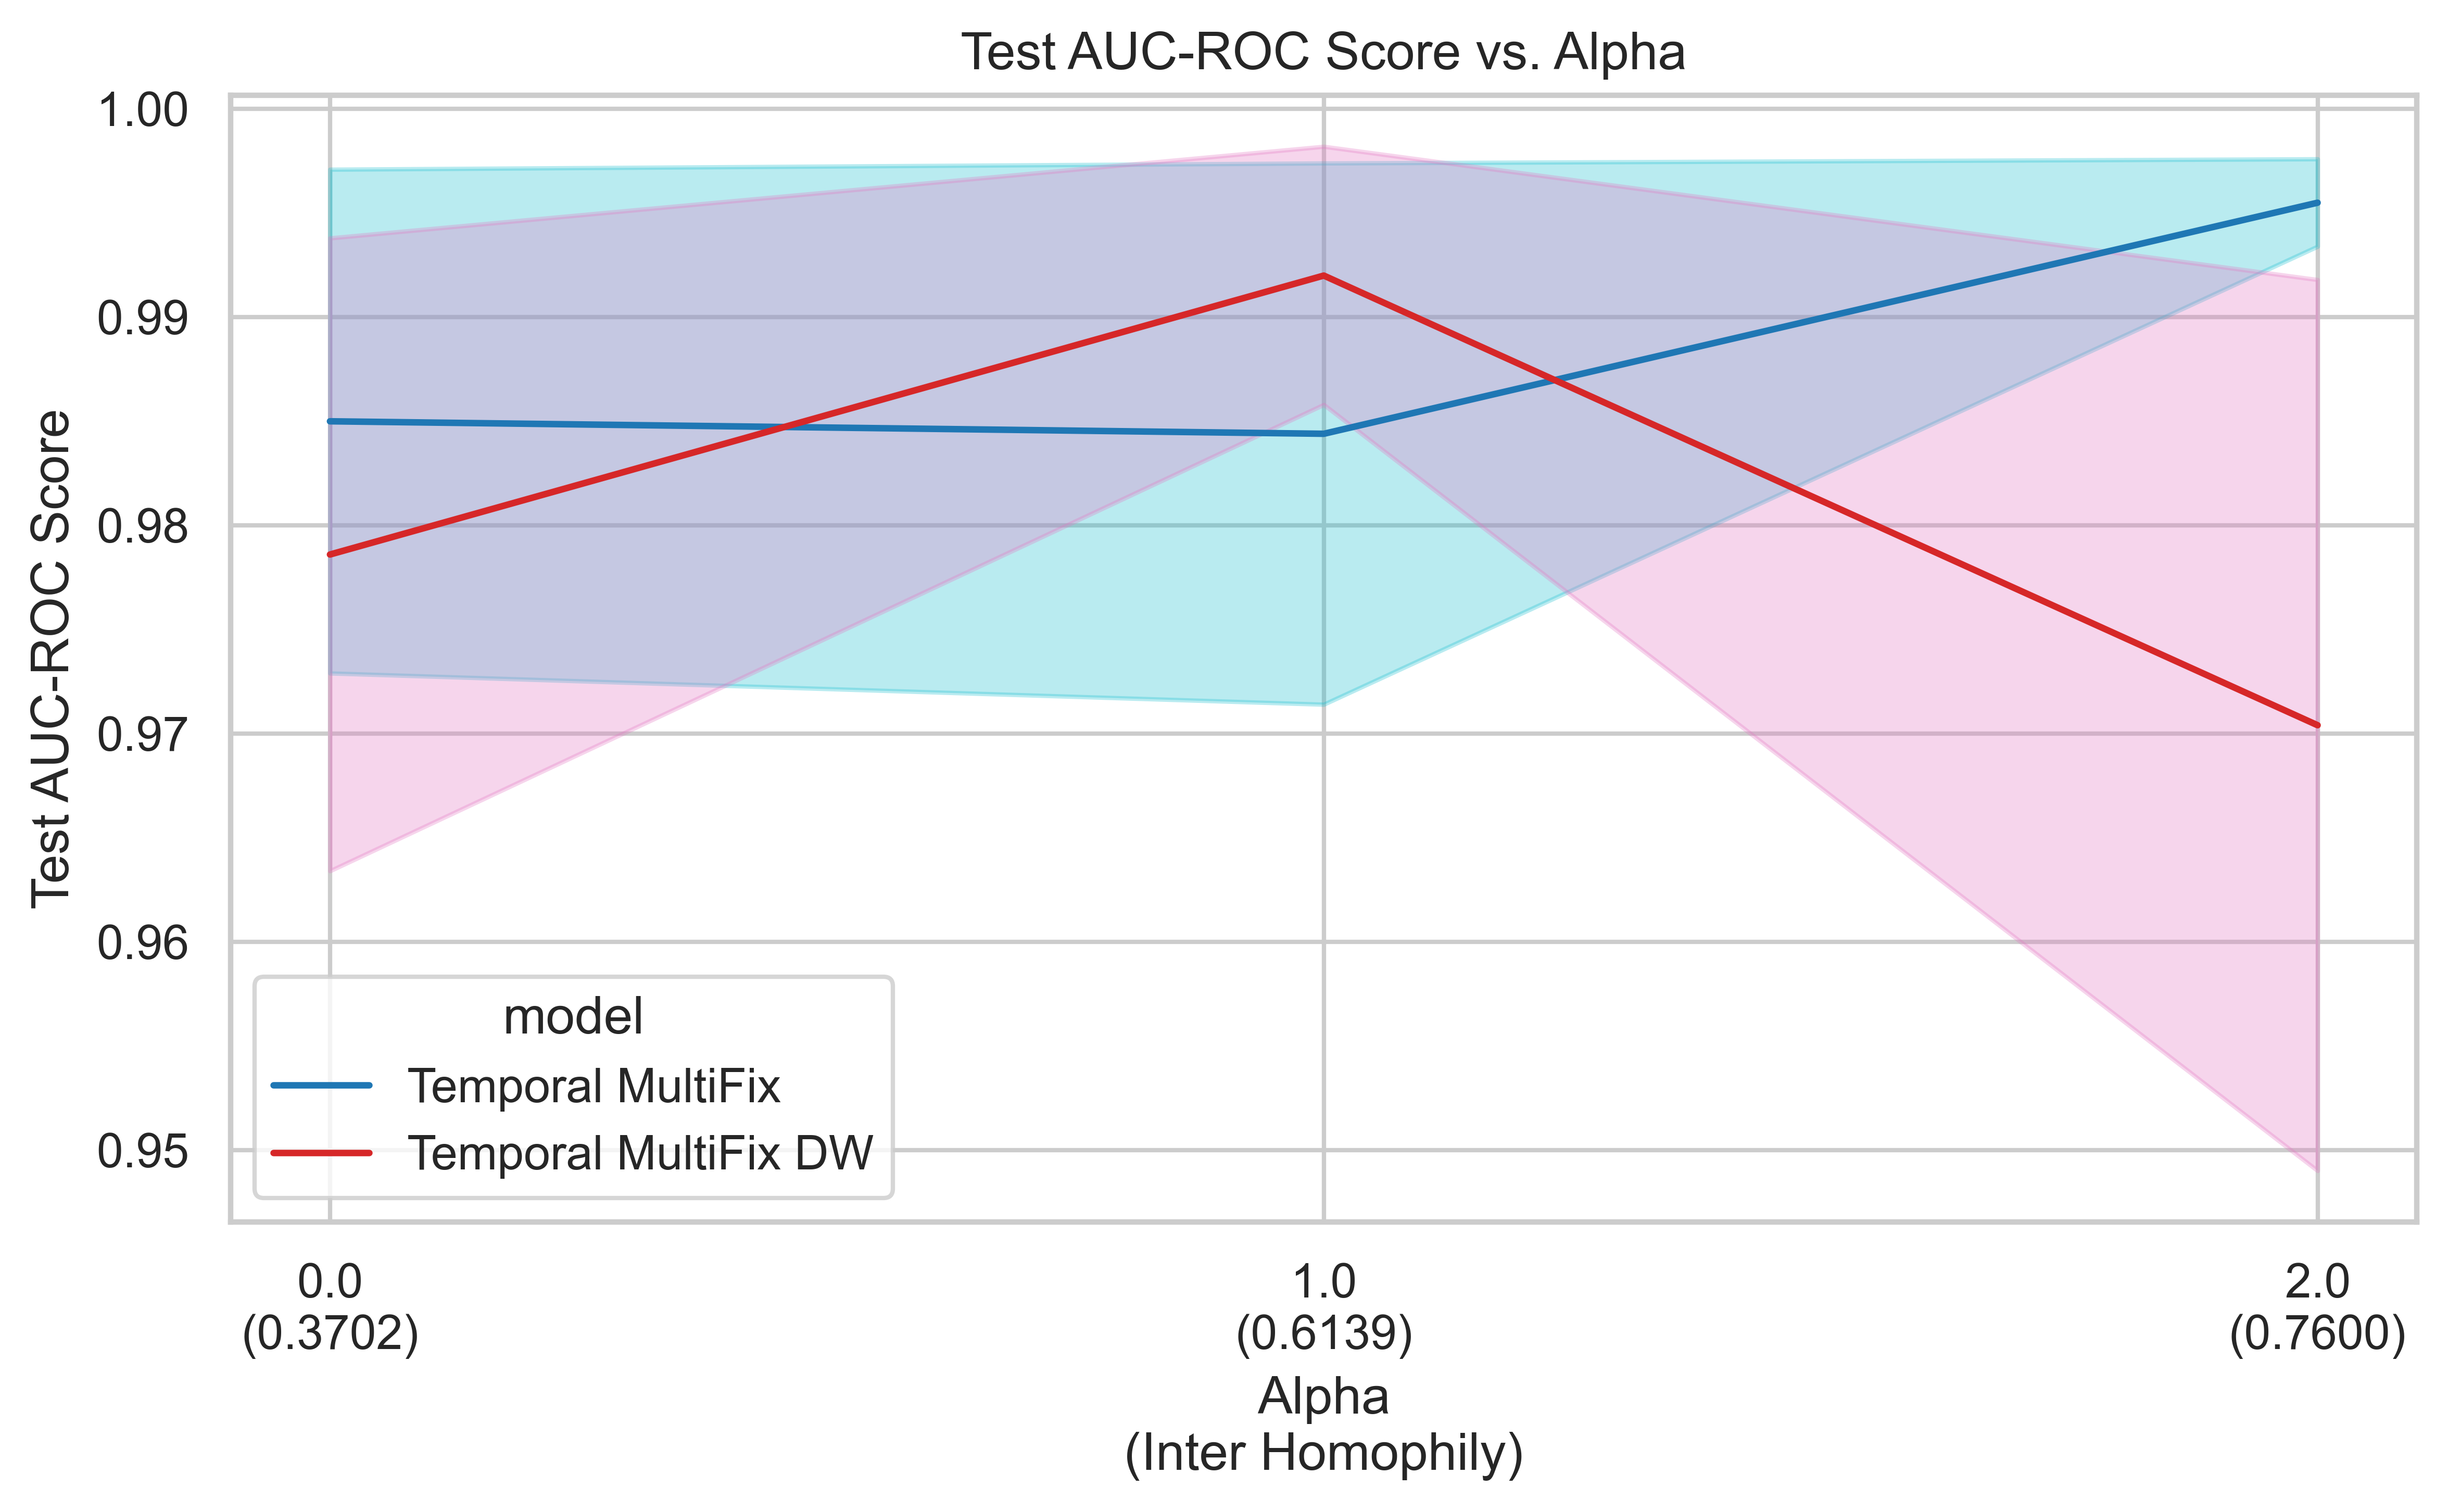

In [18]:
metrics = [
    ("test_loss_mean", "test_loss_std", "Test BCE Loss"),
    ("test_f1_macro_mean", "test_f1_macro_std", "Test Macro F1 Score"),
    ("test_f1_micro_mean", "test_f1_micro_std", 'Test Micro F1 Score'),
    ("test_ap_macro_mean", "test_ap_macro_std", "Test Macro Avg. Precision Score"),
    ("test_auc_roc_mean", "test_auc_roc_std", "Test AUC-ROC Score"),
]

# Set style
sns.set(style="whitegrid")
colors = [("tab:blue", "tab:cyan"), ("tab:red","tab:pink"), ("tab:green", "tab:olive")]

# Create a plot for each metric
for mean_col, std_col, metric in metrics:
    plt.figure(figsize=(8, 5), dpi=600)
    
    for i, model in enumerate(df['model_name'].unique()):
        subset = df[(df['model_name'] == model) & (df['alpha'] <= 3)]
        # plt.errorbar(
        #     # subset["homophily"],
        #     subset["alpha"],
        #     subset[mean_col],
        #     yerr=subset[std_col],
        #     label=model,
        #     marker='o',
        #     capsize=4
        # )

        plt.plot(subset["alpha"], subset[mean_col], label=f'{model}', color=colors[i][0])
        plt.fill_between(subset["alpha"], subset[mean_col] - subset[std_col], subset[mean_col] + subset[std_col],
                         color=colors[i][1], alpha=0.3, label='_nolegend_')

    # Build custom tick labels
    unique_alphas = sorted(subset["alpha"].unique())
    ticks = unique_alphas
    tick_labels = [
        f"{alpha:.1f}\n({subset[subset['alpha'] == alpha]['homophily'].iloc[0]:.4f})"
        for alpha in ticks
    ]
    plt.xticks(ticks, tick_labels)

    # plt.title(f"{mean_col.replace('_mean', '').replace('_', ' ').title()} vs. Homophily")
    plt.title(f"{metric} vs. Alpha")
    # plt.xlabel("Homophily")
    plt.xlabel("Alpha\n(Inter Homophily)")
    plt.ylabel(metric)
    plt.legend(title="model")
    # plt.xscale("log")
    plt.tight_layout()
    plt.show()